## Neuroblastoma + GBM public Dataset Analysis
- **Created**: 2021-07-27
- **GOAL**: Experiment with different number of PCs and resolutions to determine the number of islands and the number of sub-clusters we should use. 

In [1]:
.libPaths(c("/scratch/samkyy/gete-gbm/renv/library/R-4.0/x86_64-pc-linux-gnu","/tmp/RtmpJsRC8Z/renv-system-library", .libPaths()))
.libPaths()

[1] "/scratch/samkyy/gete-gbm/renv/library/R-4.0/x86_64-pc-linux-gnu"                       
[2] "/home/samkyy/R/x86_64-pc-linux-gnu-library/4.0"                                        
[3] "/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/r/4.0.2/lib64/R/library"

In [2]:
resultsPath <- "~/scratch/gete-gbm/results"

In [20]:
library(Seurat)
library(Matrix)
library(ggplot2)
library(cowplot)
library(genefilter)
library(tidyverse)
library(RCurl)
library(scales)
# library(SingleCellExperiment)
library(AnnotationHub)
library(ensembldb)
# Packages for figure layout formatting
library(grid)
library(gridExtra)
# Packages for Gene Ontology
library(GOstats)
library(org.Hs.eg.db)
# library(monocle3)


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots



Attaching package: ‘genefilter’


The following object is masked from ‘package:patchwork’:

    area


The following objects are masked from ‘package:MatrixGenerics’:

    rowSds, rowVars


The following objects are masked from ‘package:matrixStats’:

    rowSds, rowVars


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse()   

In [21]:
source("~/scratch/gete-gbm/bin/util.R")
source("~/scratch/gete-gbm/bin/util_seurat.R")
source("~/scratch/gete-gbm/bin/util_go.R")
source("~/scratch/gete-gbm/bin/util_viz.R")
source("~/scratch/gete-gbm/bin/util_monocle3.R")

## Re-integrate Merged GBM + Neuroblastoma Datasets at dim=25
2021-07-27 (started)
- Redo PCA with the original seurat objects. 
- Transfer the metadata from the newest object to the original one. 
- Redo PCA with 5 more PCs than I did last time (PC25). Try to aim for keeping around 90% of the information 
- Keep a list of seurat objects each which differ in the number of PCs I decide to keep
- Perform UMAP analysis at different resolutions (do it on the same seurat object so it can be easily compared. Use Idents() to select the labels when visualizing the UMAPs

In [6]:
## Load most recent seurat object saved from neuroblastoma.ipynb
load("~/scratch/gete-gbm/results/2021-07-27/ge_gbm.sc.int.umap0.7_gsea.RData")
load("~/scratch/gete-gbm/results/2021-07-27/gte_gbm.sc.int.umap0.7_gsea.RData")

In [65]:
## Load seurat object with GBM + NCS datasets merged. 
load("/home/samkyy/scratch/gete-gbm/results/2021-06-11/merged_ge_gbmsc2.RData")
load("/home/samkyy/scratch/gete-gbm/results/2021-06-11/merged_gte_gbmsc2.RData")

In [25]:
ls()

[1] "allGOgenes"             "ann"                    "barplotByGene"         
 [4] "class"                  "createDF"               "extractCellsbyCluster" 
 [7] "extractCellsbySample"   "ge_gbm.sc"              "ge_gbm.sc.int.umap0.7" 
[10] "geneontology"           "genesbyGO"              "GOBarPlots"            
[13] "gte_gbm.sc"             "gte_gbm.sc.int.umap0.7" "integrateObjects"      
[16] "intObjects"             "makeGOsummary"          "makeGOtable"           
[19] "mapped_seqs"            "mkdirToday"             "mostVariableFeatures"  
[22] "pieByGene"              "ref2eg"                 "setwdToday"            
[25] "top10VarFeatures"       "umapExpLvls"            "universe"



2021-07-28: Perform Splitting, Integration, Scaling, PCA and UMAP again.

In [26]:
## Fill Metadata Information
ge_gbm.sc$sample <- `ge_gbm.sc.int.umap0.7`$sample
ge_gbm.sc$MGMTme <- `ge_gbm.sc.int.umap0.7`$MGMTme
ge_gbm.sc$sampleCombined <- `ge_gbm.sc.int.umap0.7`$sampleCombined

gte_gbm.sc$sample <- `gte_gbm.sc.int.umap0.7`$sample ## should have been ge labels instead. 
gte_gbm.sc$MGMTme <- `gte_gbm.sc.int.umap0.7`$MGMTme
gte_gbm.sc$sampleCombined <- `gte_gbm.sc.int.umap0.7`$sampleCombined

In [7]:
sampleFactors <- levels(ge_gbm.sc.int.umap0.7$sample)
cSampleFactors <- levels(ge_gbm.sc.int.umap0.7$sampleCombined)
gbmSubtypes_ge <- ge_gbm.sc.int.umap0.7$gbm_subtype
gbmSubtypes_gte <- gte_gbm.sc.int.umap0.7$gbm_subtype
gbmSubtypeLevels <- levels(ge_gbm.sc.int.umap0.7$gbm_subtype)

In [8]:
rm(ge_gbm.sc.int.umap0.7)
rm(gte_gbm.sc.int.umap0.7)

Parameters for Normalization:
- LogNormalization (default) -- Feature counts for each cell are divided by the total counts for that cell and multiplied by the scale.factor. This is then natural-log transformed using log1p.

Parameters for Find Variable Features:
- Selection.method -- vst
- Number of Features -- 2500

In [28]:
intObjects <- mostVariableFeatures(s_obj = list(ge_gbm.sc, gte_gbm.sc), meta.group = "sample")

Number of seurat objects:  2 
Splitting seurat objects by sample 


Centering and scaling data matrix



Normalize object:  1 by sample 
Processing sample : 1 
Processing sample : 2 
Processing sample : 3 
Processing sample : 4 
Processing sample : 5 
Processing sample : 6 
Processing sample : 7 
Processing sample : 8 
Processing sample : 9 
Processing sample : 10 
Processing sample : 11 
Processing sample : 12 
Processing sample : 13 
Processing sample : 14 
Processing sample : 15 


Centering and scaling data matrix



Normalize object:  2 by sample 
Processing sample : 1 
Processing sample : 2 
Processing sample : 3 
Processing sample : 4 
Processing sample : 5 
Processing sample : 6 
Processing sample : 7 
Processing sample : 8 
Processing sample : 9 
Processing sample : 10 
Processing sample : 11 
Processing sample : 12 
Processing sample : 13 
Processing sample : 14 
Processing sample : 15 


In [29]:
length(intObjects)

[1] 2

Number of seurat objects:  2 


Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 9478 rows containing missing values (geom_point)."


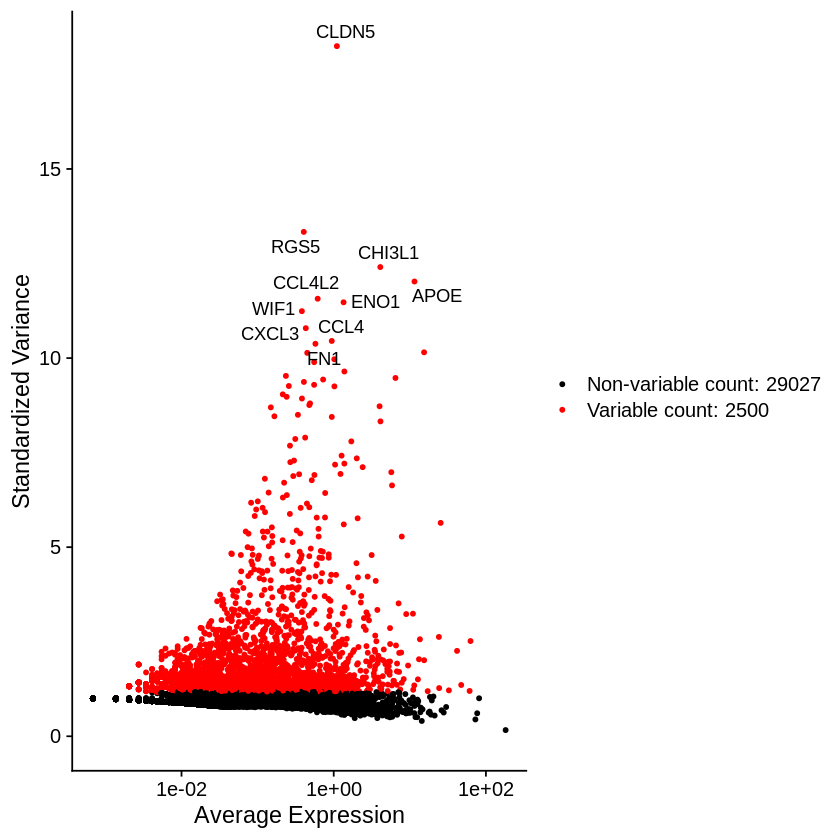

In [38]:
p <- top10VarFeatures(intObjects)
p[[1]][[1]]

In [40]:
length(p)
length(p[[1]])

[1] 2

[1] 15

In [43]:
# Save figures
size = 7
pdf("~/scratch/gete-gbm/results/2021-07-27/r_gbmsc_ge_top10VariableFeaturesbySample.pdf", 
    width = size*5, height = size*2)
grid.arrange(p[[1]][[1]], p[[1]][[2]],p[[1]][[3]], p[[1]][[4]], p[[1]][[5]],
             p[[1]][[6]], p[[1]][[7]],p[[1]][[8]], p[[1]][[9]], p[[1]][[10]],
             p[[1]][[11]], p[[1]][[12]],p[[1]][[13]], p[[1]][[14]], p[[1]][[15]],nrow=3, 
             top = "GBM + Neuroblastoma samples\nhg38")
dev.off()

pdf("~/scratch/gete-gbm/results/2021-07-27/r_gbmsc_gte_top10VariableFeaturesbySample.pdf", 
    width = size*5, height = size*2)
grid.arrange(p[[2]][[1]], p[[2]][[2]],p[[2]][[3]], p[[2]][[4]], p[[2]][[5]],
             p[[2]][[6]], p[[2]][[7]],p[[2]][[8]], p[[2]][[9]], p[[2]][[10]],
             p[[2]][[11]], p[[2]][[12]],p[[2]][[13]], p[[2]][[14]], p[[2]][[15]],nrow=3, 
             top = "GBM + Neuroblastoma samples\nhg38+Retrotransposons")
dev.off()

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 9478 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 9859 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 9850 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 5680 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 10949 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 8991 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced i

png 
  2

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 9372 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 9746 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 9731 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 5524 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 10852 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 8893 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced i

png 
  2

The variable feature plots look acceptable (no samples with most variable features being mitochondrial genes). 

Procede to integration

In [30]:
intObjects <- integrateObjects(s_list = intObjects, folderDate = "2021-07-27", nDims = 25)

Number of seurat objects:  2 
Results Folder Date:  2021-07-27 
Results number of dimensions:  25 
Integrating seurat object:  1 
Number of samples in this seurat object 15 


Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3918 anchors

Filtering anchors

	Retained 2118 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3952 anchors

Filtering anchors

	Retained 2226 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4374 anchors

Filtering anchors

	Retained 3170 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5299 anchors

Filtering anchors

	Retained 1896 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6129 anchors

Filtering anchors

	Retained 2093 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6240 anchors

Filtering anchors

	Retained 2165 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5276 anchors


Finding anchors

	Found 2516 anchors

Filtering anchors

	Retained 873 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 14650 anchors

Filtering anchors

	Retained 2924 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6108 anchors

Filtering anchors

	Retained 611 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5545 anchors

Filtering anchors

	Retained 1267 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 14097 anchors

Filtering anchors

	Retained 1741 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2410 anchors

Filtering anchors

	Retained 892 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5007 anchors

Filtering anchors

	Retained 1251 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6172 anchors

Filtering anchors

	Retai

Object # 1 Saved
Integrating seurat object:  2 
Number of samples in this seurat object 15 


Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3862 anchors

Filtering anchors

	Retained 2126 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3884 anchors

Filtering anchors

	Retained 2157 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4411 anchors

Filtering anchors

	Retained 3377 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5288 anchors

Filtering anchors

	Retained 1927 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6138 anchors

Filtering anchors

	Retained 1988 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6260 anchors

Filtering anchors

	Retained 2019 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5187 anchors


Finding anchors

	Found 2518 anchors

Filtering anchors

	Retained 840 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 14472 anchors

Filtering anchors

	Retained 3056 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6033 anchors

Filtering anchors

	Retained 659 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5467 anchors

Filtering anchors

	Retained 1182 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 13940 anchors

Filtering anchors

	Retained 2758 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2393 anchors

Filtering anchors

	Retained 833 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5020 anchors

Filtering anchors

	Retained 1473 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6142 anchors

Filtering anchors

	Retai

Object # 2 Saved


In [31]:
file.rename(from=c("~/scratch/gete-gbm/results/2021-07-27/temp_1.rds",
                  "~/scratch/gete-gbm/results/2021-07-27/temp_2.rds"), 
           to = c("~/scratch/gete-gbm/results/2021-07-27/gbmscGEint.rds",
                 "~/scratch/gete-gbm/results/2021-07-27/gbmscGTEint.rds"))

[1] TRUE TRUE

## PCA
2021-07-28:

In [4]:
intObjects <- vector(mode="list", length=2)
intObjects[[1]]<- readRDS("~/scratch/gete-gbm/results/2021-07-27/gbmscGEint.rds")
intObjects[[2]]<- readRDS("~/scratch/gete-gbm/results/2021-07-27/gbmscGTEint.rds")

In [5]:
names(intObjects) <- c("GE", "GTE")

In [33]:
# specify that we will perform downstream analysis on the corrected data note that the original
# unmodified data still resides in the 'RNA' assay
DefaultAssay(intObjects[[1]]) <- "integrated"
DefaultAssay(intObjects[[2]]) <- "integrated"

In [34]:
# Run the standard workflow for visualization and clustering (ScaleData, RunPCA, RunUMAP, FindNeighbors, FindClusters)
intObjects[[1]] <- ScaleData(object = intObjects[[1]], verbose = FALSE)
intObjects[[2]] <- ScaleData(object = intObjects[[2]], verbose = FALSE)

In [35]:
# Run PCA and UMAP ~10min 
intObjects[[1]] <- RunPCA(object = intObjects[[1]], npcs = 25, verbose = FALSE)

# Run PCA and UMAP ~10min
intObjects[[2]] <- RunPCA(object = intObjects[[2]], npcs = 25, verbose = FALSE)

In [47]:
save(intObjects,file="~/scratch/gete-gbm/results/2021-07-27/gbmsc_ge_gte_PCA.RData")

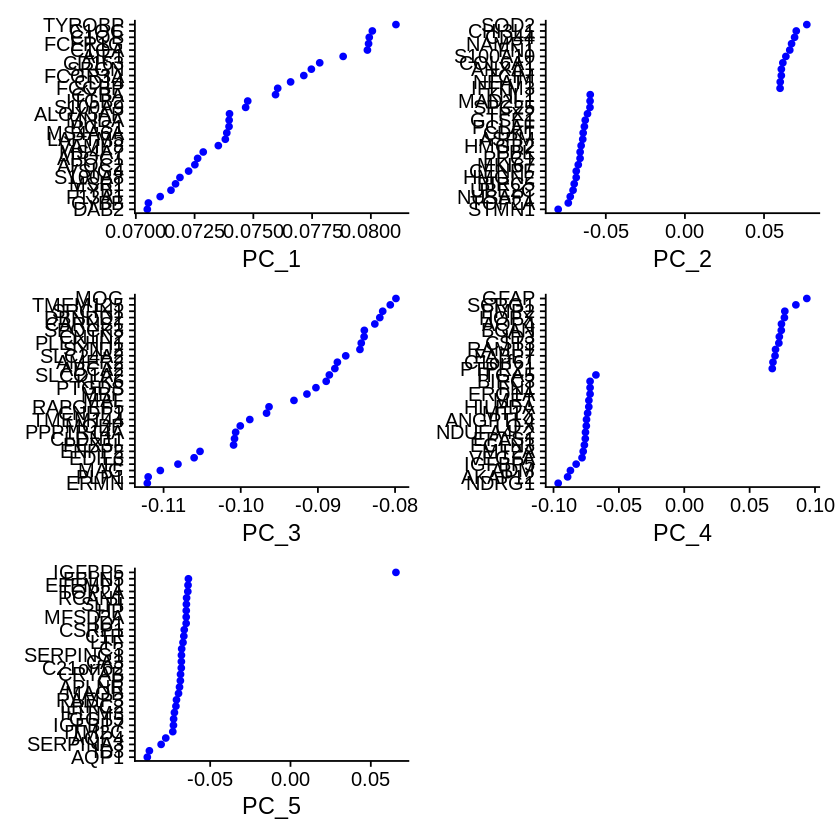

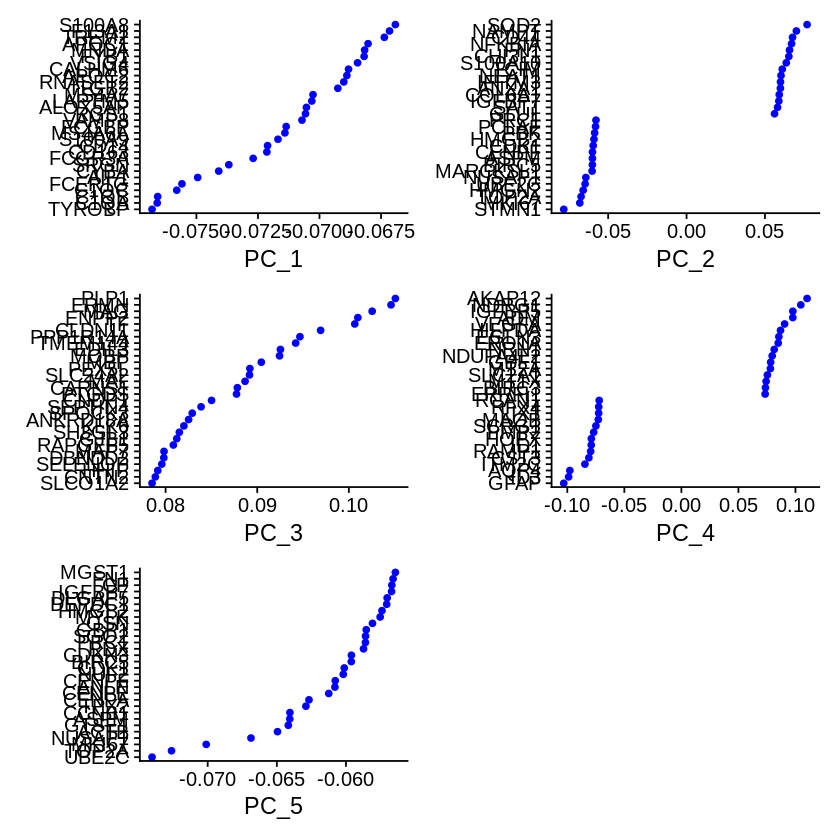

In [34]:
VizDimLoadings(intObjects[[1]], dims = 1:5, reduction = "pca")
VizDimLoadings(intObjects[[2]], dims = 1:5, reduction = "pca")

In [54]:
## Heatmaps for each PC (GE)
size <- 7
pdf("~/scratch/gete-gbm/results/2021-07-27/r_gbmsc_ge_PCHeatmaps.pdf", 
    width = size*3, height = size*7)
DimHeatmap(intObjects[[1]], dims = 1:25, cells = 1000, balanced = TRUE, ncol=3, combine = FALSE)
dev.off()

png 
  2

In [56]:
## Heatmaps for each PC (GTE)
pdf("~/scratch/gete-gbm/results/2021-07-27/r_gbmsc_gte_PCHeatmaps.pdf", 
    width = size*3, height = size*7)
DimHeatmap(intObjects[[2]], dims = 1:25, cells = 1000, balanced = TRUE, ncol=3, combine = FALSE)
dev.off()

png 
  2

In [57]:
# Which PCAs should we include in our analyses? 
p <- ElbowPlot(object = intObjects[[1]], ndims = 25) 
p2 <- ElbowPlot(object = intObjects[[2]], ndims = 25)

pdf("~/scratch/gete-gbm/results/2021-07-27/r_gbmsc_ge_gte_PCElbowPlots.pdf", 
    width = size*2, height = size)
grid.arrange(p, p2, nrow=1, 
             top = "GBM + Neuroblastoma samples (version 2)")
dev.off()

png 
  2

Warning message:
"Removed 35000 rows containing missing values (geom_point)."
Warning message:
"Removed 35000 rows containing missing values (geom_point)."


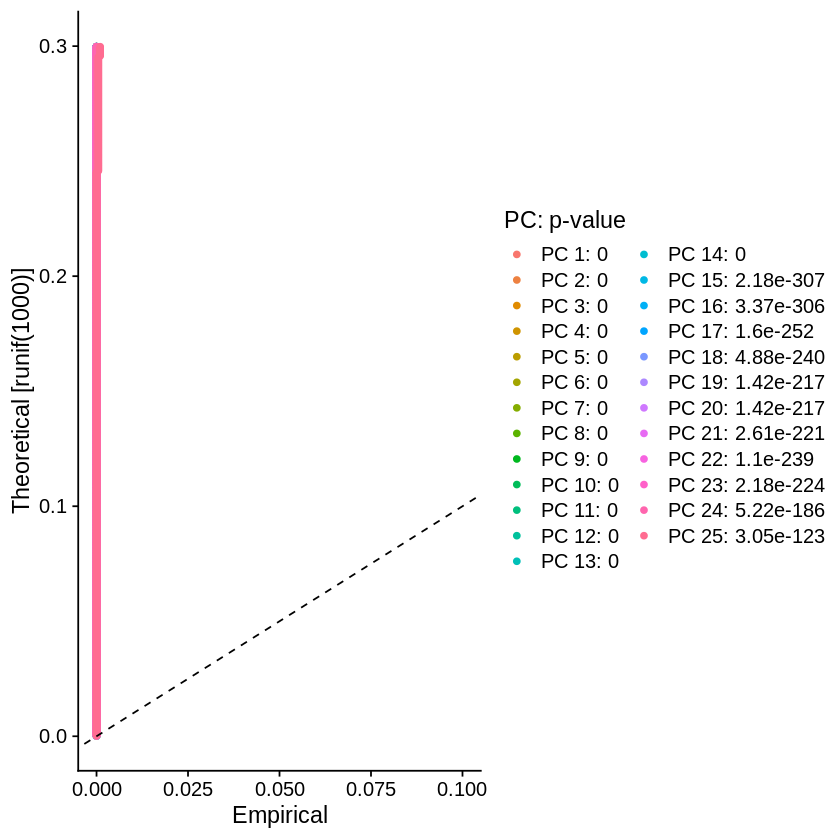

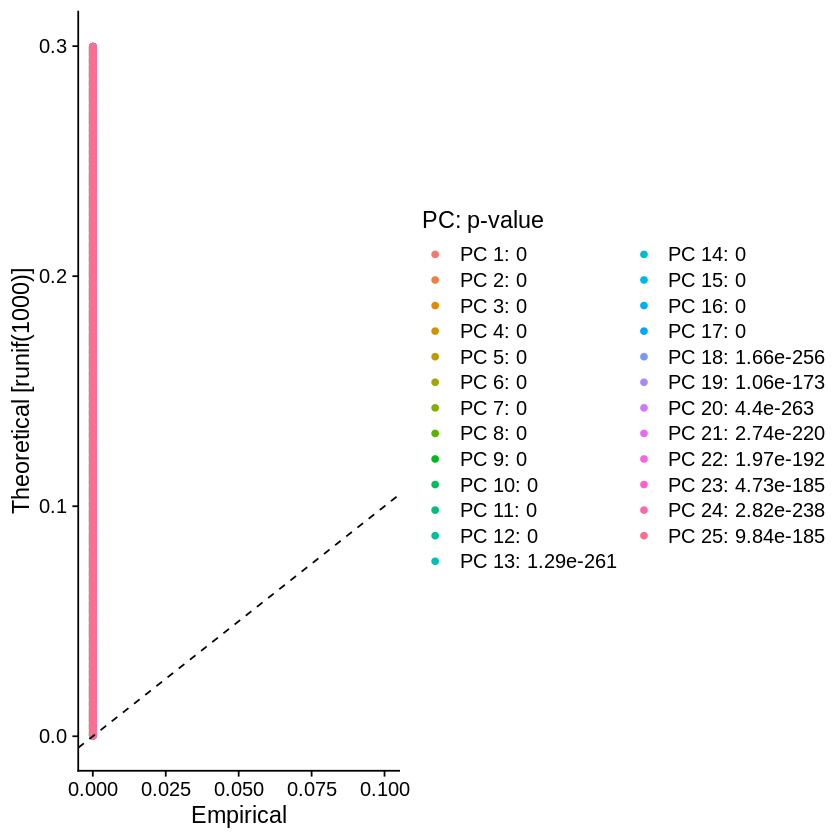

In [36]:
# NOTE: This process can take a long time for big datasets, comment out for expediency. More
# approximate techniques such as those implemented in ElbowPlot() can be used to reduce
# computation time
jackPlots <- vector(mode="list", length=2)
jackPlots[[1]] <- JackStraw(intObjects[[1]], num.replicate = 100, dims = 25)
jackPlots[[1]] <- ScoreJackStraw(jackPlots[[1]], dims = 1:25)
JackStrawPlot(jackPlots[[1]], dims = 1:25)
# NOTE: This process can take a long time for big datasets, comment out for expediency. More
# approximate techniques such as those implemented in ElbowPlot() can be used to reduce
# computation time
jackPlots[[2]] <- JackStraw(intObjects[[2]], num.replicate = 100, dims = 25)
jackPlots[[2]] <- ScoreJackStraw(jackPlots[[2]], dims = 1:25)
JackStrawPlot(jackPlots[[2]], dims = 1:25)

Warning message:
"Removed 5000 rows containing missing values (geom_point)."
Warning message:
"Removed 5000 rows containing missing values (geom_point)."


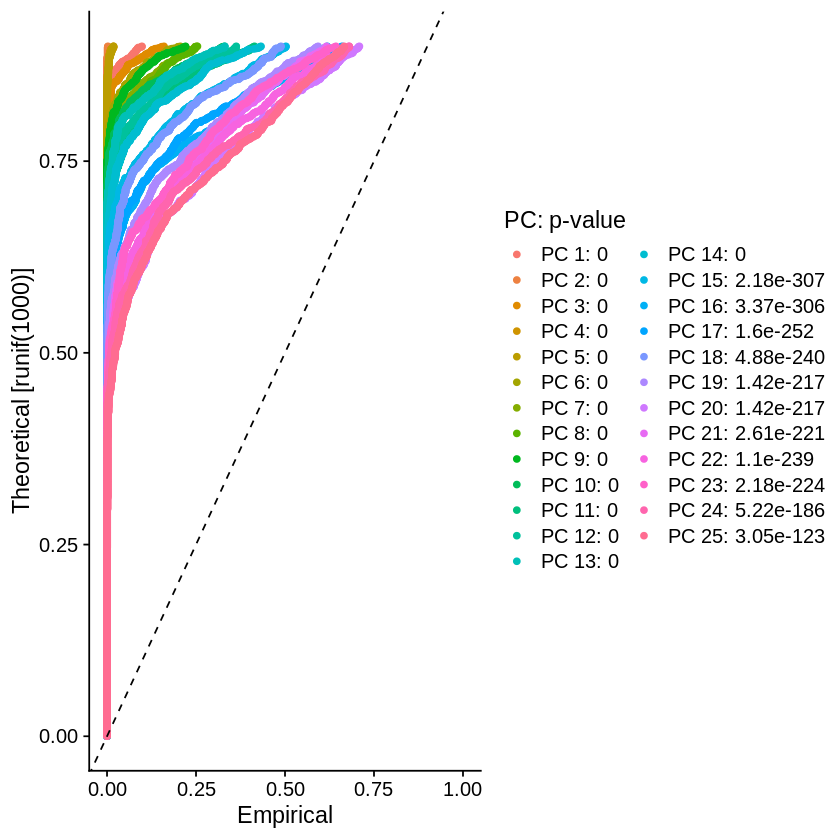

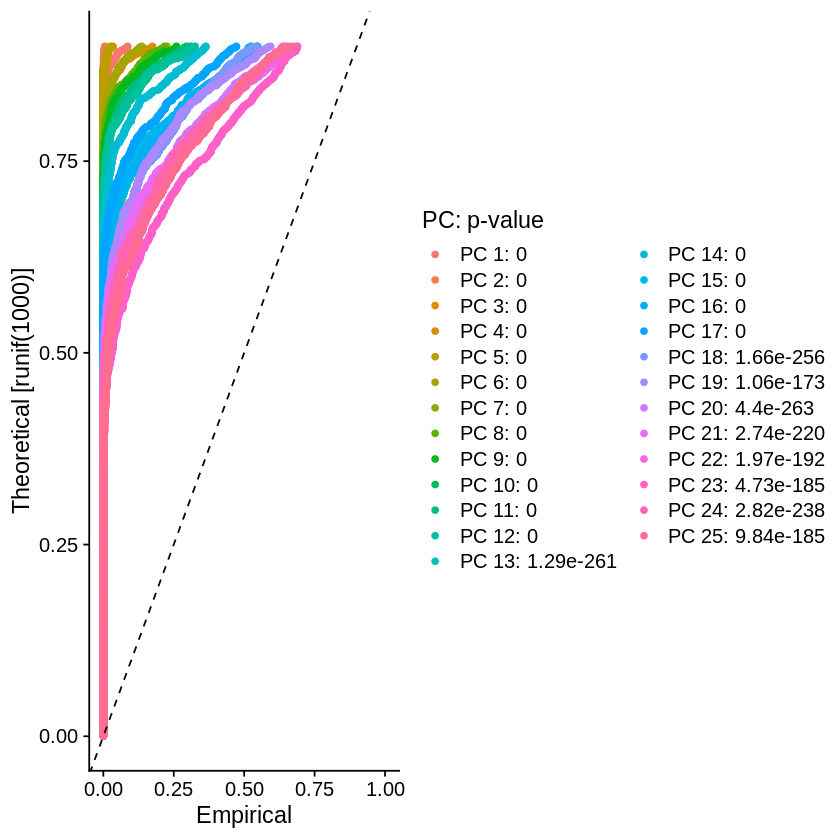

In [39]:
JackStrawPlot(jackPlots[[1]], dims = 1:25, xmax = 1.0,ymax = 0.9)
JackStrawPlot(jackPlots[[2]], dims = 1:25, xmax = 1.0,ymax = 0.9)

In [45]:
p <- JackStrawPlot(jackPlots[[1]], dims = 1:25, xmax = 1.0,ymax = 0.9)
p2 <- JackStrawPlot(jackPlots[[2]], dims = 1:25, xmax = 1.0,ymax = 0.9)

size <- 7
pdf("~/scratch/gete-gbm/results/2021-07-27/r_gbmsc_ge_gte_PCJackStraw.pdf", 
    width = size*3, height = size*1.5)
grid.arrange(p, p2, nrow=1, 
             top = "JackStraw Plots of GBM + Neuroblastoma samples (vers. 2)")
dev.off()

Warning message:
"Removed 5000 rows containing missing values (geom_point)."
Warning message:
"Removed 5000 rows containing missing values (geom_point)."


png 
  2

## Check QC (post integration)

In [9]:
## Set sample as the active.ident (currently a vector of characters)
intObjects[[1]]$sample <- factor(intObjects[[1]]$sample, levels=sampleFactors)
intObjects[[2]]$sample <- factor(intObjects[[1]]$sample, levels=sampleFactors) 

intObjects[[1]]@active.ident <- intObjects[[1]]$sample
intObjects[[2]]@active.ident <- intObjects[[2]]$sample

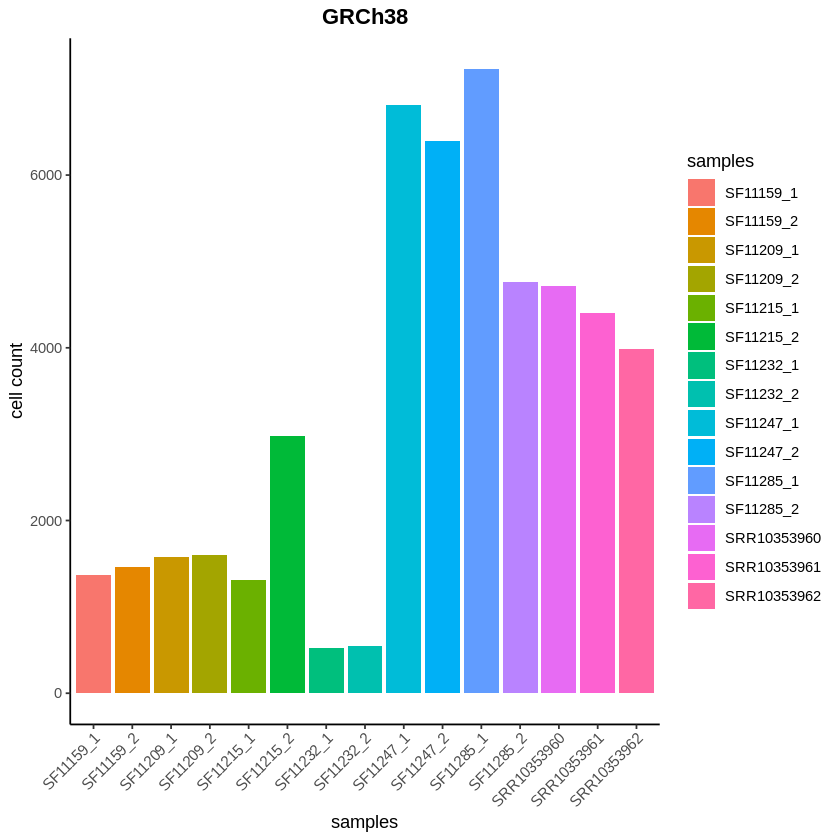

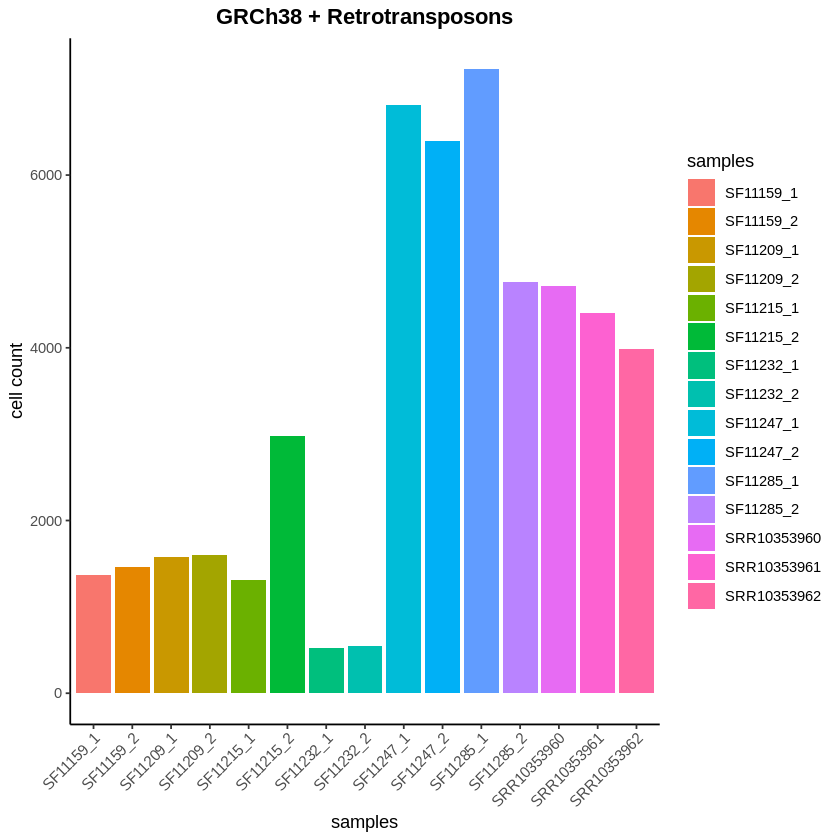

In [84]:
p <- intObjects[[1]]@meta.data %>%
    ggplot(aes(x=sample, fill=sample)) + 
    labs(fill="samples") + labs(x = "samples", y = "cell count") +
    scale_x_discrete(labels = sampleFactors) +
    scale_fill_discrete(labels = sampleFactors) +
    geom_bar() +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("GRCh38") + theme(plot.title = element_text(hjust=0.5, face="bold"))

p2 <- intObjects[[2]]@meta.data %>%
    ggplot(aes(x=sample, fill=sample)) + 
    labs(fill="samples") + labs(x = "samples", y = "cell count") +
    scale_x_discrete(labels = sampleFactors) +
    scale_fill_discrete(labels = sampleFactors) +
    geom_bar() +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("GRCh38 + Retrotransposons") + theme(plot.title = element_text(hjust=0.5, face="bold"))

p
p2

In [101]:
# Visualize QC metrics as a violin plot
p <- list(VlnPlot(intObjects[[1]], features = "nFeature_RNA", pt.size = 0) + geom_boxplot(width=0.08,fill="white"),
          VlnPlot(intObjects[[1]], features = "nCount_RNA", pt.size = 0) + geom_boxplot(width=0.08,fill="white"),
          VlnPlot(intObjects[[1]], features = "mitoRatio", pt.size = 0) + geom_boxplot(width=0.08,fill="white") )
p2 <- list(VlnPlot(intObjects[[2]], features = "nFeature_RNA", pt.size = 0) + geom_boxplot(width=0.08,fill="white"),
          VlnPlot(intObjects[[2]], features = "nCount_RNA", pt.size = 0) + geom_boxplot(width=0.08,fill="white"),
          VlnPlot(intObjects[[2]], features = "mitoRatio", pt.size = 0) + geom_boxplot(width=0.08,fill="white") )

# Save figures
size = 7
pdf("~/scratch/gete-gbm/results/2021-07-27/r_gbmsc-int_Gene_Count_MitoRatio.pdf", 
    width = size*4, height = size*3)
grid.arrange(p[[1]], p2[[1]],
             p[[2]], p2[[2]],
             p[[3]], p2[[3]], nrow=3, 
             top = "GBM + Neuroblastoma samples\nhg38", bottom = "GBM + Neuroblastoma samples\nhg38+Retrotransposons")
dev.off()

png 
  2

In [87]:
summary(intObjects[[1]]$nFeature_RNA)
summary(intObjects[[2]]$nFeature_RNA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    265    1309    1928    2071    2671   10386 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    400    1487    2137    2281    2906   10994 

## Checking QC (pre integration)
- 2021-08-02

In [4]:
## Load most recent seurat object saved from neuroblastoma.ipynb
load("~/scratch/gete-gbm/results/2021-07-27/ge_gbm.sc.int.umap0.7_gsea.RData")
load("~/scratch/gete-gbm/results/2021-07-27/gte_gbm.sc.int.umap0.7_gsea.RData")

In [5]:
## Load seurat object with GBM + NCS datasets merged. 
load("/home/samkyy/scratch/gete-gbm/results/2021-06-11/merged_ge_gbmsc2.RData")
load("/home/samkyy/scratch/gete-gbm/results/2021-06-11/merged_gte_gbmsc2.RData")

In [6]:
ls()

[1] "allGOgenes"             "ann"                    "barplotByGene"         
 [4] "class"                  "createDF"               "extractCellsbyCluster" 
 [7] "extractCellsbySample"   "ge_gbm.sc"              "ge_gbm.sc.int.umap0.7" 
[10] "geneontology"           "genesbyGO"              "GOBarPlots"            
[13] "gte_gbm.sc"             "gte_gbm.sc.int.umap0.7" "integrateObjects"      
[16] "makeGOsummary"          "makeGOtable"            "mapped_seqs"           
[19] "mkdirToday"             "mostVariableFeatures"   "pieByGene"             
[22] "ref2eg"                 "setwdToday"             "top10VarFeatures"      
[25] "umapExpLvls"            "universe"



2021-07-28: Perform Splitting, Integration, Scaling, PCA and UMAP again.

In [8]:
## Fill Metadata Information
ge_gbm.sc$sample <- factor(`ge_gbm.sc.int.umap0.7`$sample, 
                           levels=levels(ge_gbm.sc.int.umap0.7$sample))
ge_gbm.sc$MGMTme <- `ge_gbm.sc.int.umap0.7`$MGMTme
ge_gbm.sc$sampleCombined <- factor(`ge_gbm.sc.int.umap0.7`$sampleCombined, 
                                   levels=levels(ge_gbm.sc.int.umap0.7$sampleCombined))

gte_gbm.sc$sample <- factor(`ge_gbm.sc.int.umap0.7`$sample, 
                           levels=levels(ge_gbm.sc.int.umap0.7$sample))
gte_gbm.sc$MGMTme <- `gte_gbm.sc.int.umap0.7`$MGMTme
gte_gbm.sc$sampleCombined <- factor(`ge_gbm.sc.int.umap0.7`$sampleCombined, 
                                   levels=levels(ge_gbm.sc.int.umap0.7$sampleCombined))

In [9]:
gbmSubtypes_ge <- ge_gbm.sc.int.umap0.7$gbm_subtype
gbmSubtypes_gte <- gte_gbm.sc.int.umap0.7$gbm_subtype
gbmSubtypeLevels <- levels(ge_gbm.sc.int.umap0.7$gbm_subtype)

In [27]:
DefaultAssay(ge_gbm.sc) <- "RNA"
DefaultAssay(gte_gbm.sc) <- "RNA"

ge_gbm.sc@active.ident <- ge_gbm.sc$sample
gte_gbm.sc@active.ident <- gte_gbm.sc$sample

In [10]:
rm(ge_gbm.sc.int.umap0.7)
rm(gte_gbm.sc.int.umap0.7)

In [30]:
dim(ge_gbm.sc)
dim(gte_gbm.sc)

[1] 31527 49670

[1] 32501 49670

In [17]:
p_cells <- @meta.data %>%
    ggplot(aes(x=sample, fill=sample)) + 
    labs(fill="samples") + labs(x = "samples", y = "cell count") +
    scale_x_discrete(labels = levels(ge_gbm.sc$sample)) +
    scale_fill_discrete(labels = levels(ge_gbm.sc$sample)) +
    geom_bar() +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("GRCh38") + theme(plot.title = element_text(hjust=0.5, face="bold"))

p2_cells <- gte_gbm.sc@meta.data %>%
    ggplot(aes(x=sample, fill=sample)) + 
    labs(fill="samples") + labs(x = "samples", y = "cell count") +
    scale_x_discrete(labels = levels(gte_gbm.sc$sample)) +
    scale_fill_discrete(labels = levels(gte_gbm.sc$sample)) +
    geom_bar() +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("GRCh38 + Retrotransposons") + theme(plot.title = element_text(hjust=0.5, face="bold"))

In [28]:
# Visualize QC metrics as a violin plot
p <- list(VlnPlot(ge_gbm.sc, features = "nFeature_RNA", pt.size = 0) + geom_boxplot(width=0.08,fill="white"),
          VlnPlot(ge_gbm.sc, features = "nCount_RNA", pt.size = 0) + geom_boxplot(width=0.08,fill="white"),
          VlnPlot(ge_gbm.sc, features = "mitoRatio", pt.size = 0) + geom_boxplot(width=0.08,fill="white") )
p2 <- list(VlnPlot(gte_gbm.sc, features = "nFeature_RNA", pt.size = 0) + geom_boxplot(width=0.08,fill="white"),
          VlnPlot(gte_gbm.sc, features = "nCount_RNA", pt.size = 0) + geom_boxplot(width=0.08,fill="white"),
          VlnPlot(gte_gbm.sc, features = "mitoRatio", pt.size = 0) + geom_boxplot(width=0.08,fill="white") )

# Save figures
resultsPath = "~/scratch/gete-gbm/results"
mkdirToday()
size = 7
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_Gene_Count_MitoRatio.pdf", 
    width = size*4, height = size*4)
grid.arrange(p_cells, p2_cells,
             p[[1]], p2[[1]],
             p[[2]], p2[[2]],
             p[[3]], p2[[3]], nrow=4, 
             top = "Pre-integration",
             left = "GBM + Neuroblastoma samples\nhg38", right = "GBM + Neuroblastoma samples\nhg38+Retrotransposons")
dev.off()

[1] "Current working directory: /scratch/samkyy/gete-gbm/results/2021-08-02"


Warning message in dir.create(file.path(maindir, subdir)):
"'/home/samkyy/scratch/gete-gbm/results/2021-08-02' already exists"


[1] "New working directory: /scratch/samkyy/gete-gbm/results/2021-08-02"


png 
  2

In [19]:
summary(ge_gbm.sc$nFeature_RNA)
summary(gte_gbm.sc$nFeature_RNA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    265    1309    1928    2071    2671   10386 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    400    1487    2137    2281    2906   10994 

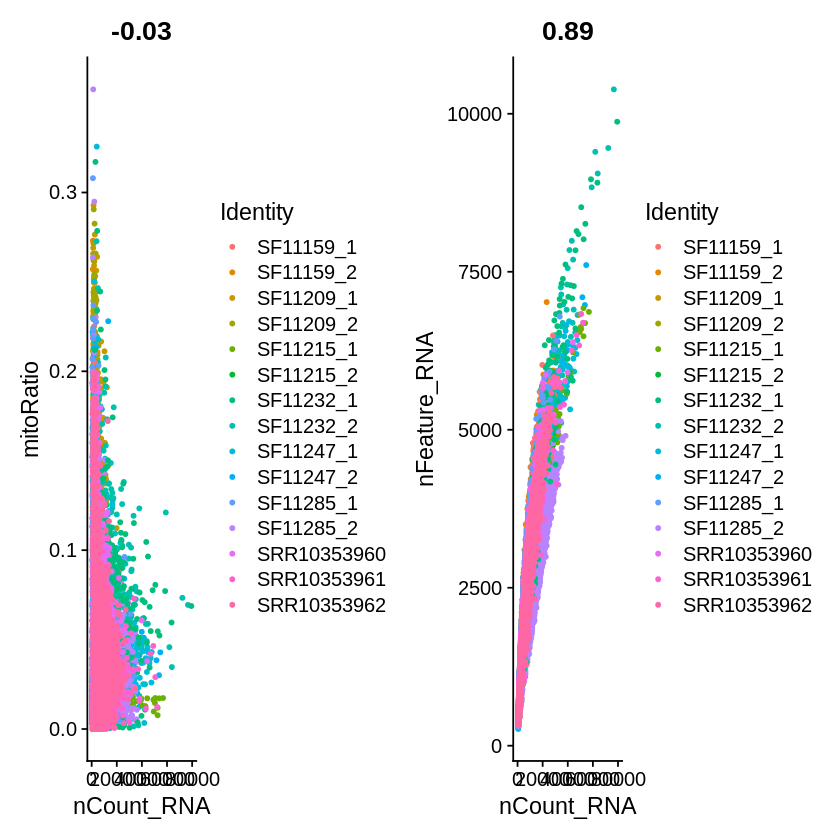

png 
  2

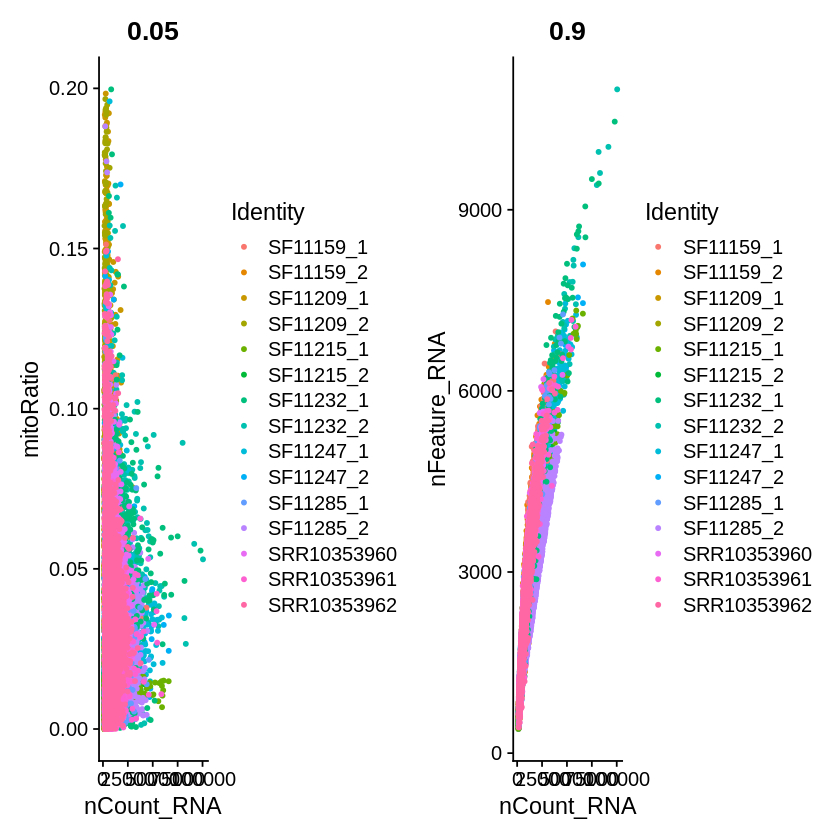

In [29]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

p <- FeatureScatter(ge_gbm.sc, feature1 = "nCount_RNA", feature2 = "mitoRatio", group.by = "sample") 
p2 <- FeatureScatter(ge_gbm.sc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA", group.by = "sample")
p + p2
p3 <- FeatureScatter(gte_gbm.sc, feature1 = "nCount_RNA", feature2 = "mitoRatio", group.by = "sample") 
p4 <- FeatureScatter(gte_gbm.sc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA", group.by = "sample")
p3 + p4

# Save figures
size = 7
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_FeatureScatter.pdf", 
    width = size*2, height = size*1)
grid.arrange(p,p2, nrow=1, 
             top = "GBM + Neuroblastoma samples\nhg38")
grid.arrange(p3,p4, nrow =1,
             top = "GBM + Neuroblastoma samples\nhg38+Retrotransposons")
dev.off()

I'll remove sample `SF11215`, because for the number of cells captured there are too few genes and transcripts captured compared to a a sample with similar number of cells like `SF11159`. I debated on removing `SF11209` as well because it had a higher mitochondrial ratio while also low number of genes per cell / transcripts per cell, but I'll keep it for now

## Re-Load, Filter, Re-integrate GBM + Neuroblastoma samples
2021-08-02:

In [7]:
## Load most recent seurat object saved from neuroblastoma.ipynb
load("~/scratch/gete-gbm/results/2021-07-27/ge_gbm.sc.int.umap0.7_gsea.RData")
load("~/scratch/gete-gbm/results/2021-07-27/gte_gbm.sc.int.umap0.7_gsea.RData")

In [8]:
## Load seurat object with GBM + NCS datasets merged. 
load("/home/samkyy/scratch/gete-gbm/results/2021-06-11/merged_ge_gbmsc2.RData")
load("/home/samkyy/scratch/gete-gbm/results/2021-06-11/merged_gte_gbmsc2.RData")

In [9]:
ls()

[1] "allGOgenes"             "ann"                    "barplotByGene"         
 [4] "class"                  "createDF"               "extractCellsbyCluster" 
 [7] "extractCellsbySample"   "ge_gbm.sc"              "ge_gbm.sc.int.umap0.7" 
[10] "geneontology"           "genesbyGO"              "GOBarPlots"            
[13] "gte_gbm.sc"             "gte_gbm.sc.int.umap0.7" "integrateObjects"      
[16] "makeGOsummary"          "makeGOtable"            "mapped_seqs"           
[19] "mkdirToday"             "mostVariableFeatures"   "pieByGene"             
[22] "ref2eg"                 "setwdToday"             "top10VarFeatures"      
[25] "umapExpLvls"            "universe"



2021-07-28: Perform Splitting, Integration, Scaling, PCA and UMAP again.

In [10]:
## Fill Metadata Information
ge_gbm.sc$sample <- factor(`ge_gbm.sc.int.umap0.7`$sample, 
                           levels=levels(ge_gbm.sc.int.umap0.7$sample))
ge_gbm.sc$MGMTme <- `ge_gbm.sc.int.umap0.7`$MGMTme
ge_gbm.sc$sampleCombined <- factor(`ge_gbm.sc.int.umap0.7`$sampleCombined, 
                                   levels=levels(ge_gbm.sc.int.umap0.7$sampleCombined))

gte_gbm.sc$sample <- factor(`ge_gbm.sc.int.umap0.7`$sample, 
                           levels=levels(ge_gbm.sc.int.umap0.7$sample))
gte_gbm.sc$MGMTme <- `gte_gbm.sc.int.umap0.7`$MGMTme
gte_gbm.sc$sampleCombined <- factor(`ge_gbm.sc.int.umap0.7`$sampleCombined, 
                                   levels=levels(ge_gbm.sc.int.umap0.7$sampleCombined))

In [11]:
gbmSubtypes_ge <- ge_gbm.sc.int.umap0.7$gbm_subtype
gbmSubtypes_gte <- gte_gbm.sc.int.umap0.7$gbm_subtype
gbmSubtypeLevels <- levels(ge_gbm.sc.int.umap0.7$gbm_subtype)

In [12]:
rm(ge_gbm.sc.int.umap0.7)
rm(gte_gbm.sc.int.umap0.7)

In [13]:
DefaultAssay(ge_gbm.sc) <- "RNA"
DefaultAssay(gte_gbm.sc) <- "RNA"

ge_gbm.sc@active.ident <- ge_gbm.sc$sample
gte_gbm.sc@active.ident <- gte_gbm.sc$sample

In [14]:
dim(ge_gbm.sc)
dim(gte_gbm.sc)

[1] 31527 49670

[1] 32501 49670

Filter out samples SF11215_1 and SF11215_2

In [15]:
head(ge_gbm.sc$sample)

GBM_AAACCTGCAATTCCTT-1 GBM_AAACCTGCACAGAGGT-1 GBM_AAACCTGGTGTGGCTC-1 
             SF11159_2              SF11159_2              SF11159_2 
GBM_AAACGGGGTCCGAATT-1 GBM_AAACGGGTCGAATGGG-1 GBM_AAAGATGGTCTCAACA-1 
             SF11159_2              SF11159_2              SF11159_2 
15 Levels: SF11159_1 SF11159_2 SF11209_1 SF11209_2 SF11215_1 ... SRR10353962

In [16]:
rm_215_ge <- subset(x = ge_gbm.sc, subset= (sample != 'SF11215_1') & (sample != 'SF11215_2') )
rm_215_gte <- subset(x = gte_gbm.sc, subset= (sample != 'SF11215_1') & (sample != 'SF11215_2') )

In [23]:
## Create a new Seurat Object with old count matrices and filter features and cells more aggressively. 
gbmsc_ge <- CreateSeuratObject(rm_215_ge@assays$RNA@counts, in.features = 1000, min.cells = 30)
gbmsc_gte <- CreateSeuratObject(rm_215_gte@assays$RNA@counts, in.features = 1000, min.cells = 30)

In [31]:
dim(gbmsc_ge)
dim(gbmsc_gte)
head(gbmsc_ge@meta.data)
head(rm_215_ge@meta.data)

[1] 22050 45375

[1] 23125 45375

orig.ident nCount_RNA nFeature_RNA
GBM_AAACCTGCAATTCCTT-1 GBM        11913      4506        
GBM_AAACCTGCACAGAGGT-1 GBM         4056      1666        
GBM_AAACCTGGTGTGGCTC-1 GBM         4312      2100        
GBM_AAACGGGGTCCGAATT-1 GBM         7246      2938        
GBM_AAACGGGTCGAATGGG-1 GBM         1706      1047        
GBM_AAAGATGGTCTCAACA-1 GBM         5157      2537

orig.ident nUMI  nGene log10GenesPerUMI mitoRatio  
GBM_AAACCTGCAATTCCTT-1 1          11916 4509  0.8964581        0.008308157
GBM_AAACCTGCACAGAGGT-1 1           4061 1671  0.8931295        0.068456045
GBM_AAACCTGGTGTGGCTC-1 1           4314 2102  0.9140969        0.070931850
GBM_AAACGGGGTCCGAATT-1 1           7251 2943  0.8985577        0.084402151
GBM_AAACGGGTCGAATGGG-1 1           1708 1049  0.9345048        0.066159251
GBM_AAAGATGGTCTCAACA-1 1           5158 2538  0.9170394        0.017642497
                       cells              sample    nCount_RNA nFeature_RNA
GBM_AAACCTGCAATTCCTT-1 AAACCTGCAATTCCTT-1 SF11159_2 11916      4509        
GBM_AAACCTGCACAGAGGT-1 AAACCTGCACAGAGGT-1 SF11159_2  4061      1671        
GBM_AAACCTGGTGTGGCTC-1 AAACCTGGTGTGGCTC-1 SF11159_2  4314      2102        
GBM_AAACGGGGTCCGAATT-1 AAACGGGGTCCGAATT-1 SF11159_2  7251      2943        
GBM_AAACGGGTCGAATGGG-1 AAACGGGTCGAATGGG-1 SF11159_2  1708      1049        
GBM_AAAGATGGTCTCAACA-1 AAAGATGGTCTCAACA-1 SF11159_2  5158      2538        
                       GBM_integrated_snn_res.0.8 GBM_seurat_clusters
GBM_AAACCTGCAATTCCTT-1 7                          7                  
GBM_AAACCTGCACAGAGGT-1 3                          3                  
GBM_AAACCTGGTGTGGCTC-1 0                          0                  
GBM_AAACGGGGTCCGAATT-1 0                          0                  
GBM_AAACGGGTCGAATGGG-1 0                          0                  
GBM_AAAGATGGTCTCAACA-1 14                         14                 
                       neuro.ident MGMTme sampleCombined nCount_integrated
GBM_AAACCTGCAATTCCTT-1 GBM1        TRUE   SF11159        0                
GBM_AAACCTGCACAGAGGT-1 GBM1        TRUE   SF11159        0                
GBM_AAACCTGGTGTGGCTC-1 GBM1        TRUE   SF11159        0                
GBM_AAACGGGGTCCGAATT-1 GBM1        TRUE   SF11159        0                
GBM_AAACGGGTCGAATGGG-1 GBM1        TRUE   SF11159        0                
GBM_AAAGATGGTCTCAACA-1 GBM1        TRUE   SF11159        0                
                       nFeature_integrated
GBM_AAACCTGCAATTCCTT-1 0                  
GBM_AAACCTGCACAGAGGT-1 0                  
GBM_AAACCTGGTGTGGCTC-1 0                  
GBM_AAACGGGGTCCGAATT-1 0                  
GBM_AAACGGGTCGAATGGG-1 0                  
GBM_AAAGATGGTCTCAACA-1 0

In [59]:
## transfer metadata from old object to new object. 

### rename orig.ident to source
gbmsc_ge@meta.data$source <- gbmsc_ge@meta.data$orig.ident
gbmsc_gte@meta.data$source <- gbmsc_gte@meta.data$orig.ident

### copy cell names to new column
gbmsc_ge@meta.data$cells <- rownames(gbmsc_ge@meta.data)
gbmsc_gte@meta.data$cells <- rownames(gbmsc_gte@meta.data)

### transfer orig.ident 
length(rownames(gbmsc_ge@meta.data))
length(rownames(gbmsc_gte@meta.data))
length(rownames(ge_gbm.sc@meta.data))
length(rownames(gte_gbm.sc@meta.data))
    
    ## df$col <- df_with_data$new_data[match(df$id, df_with_data$id)]
    ## match returns a vector of integers that will select the rows in df_with_data to update df column(s)
gbmsc_ge@meta.data$orig.ident <- ge_gbm.sc$orig.ident[match(rownames(gbmsc_ge@meta.data), rownames(ge_gbm.sc@meta.data))]
gbmsc_gte@meta.data$orig.ident <- gte_gbm.sc$orig.ident[match(rownames(gbmsc_gte@meta.data), rownames(gte_gbm.sc@meta.data))]

[1] 45375

[1] 45375

[1] 49670

[1] 49670

In [61]:
## Compute Quality Control Metrics

# number of genes per UMI 
gbmsc_ge$log10GenesPerUMI <- log10(gbmsc_ge$nFeature_RNA) / log10(gbmsc_ge$nCount_RNA)
gbmsc_gte$log10GenesPerUMI <- log10(gbmsc_gte$nFeature_RNA) / log10(gbmsc_gte$nCount_RNA)

# mitochondrial ratio
gbmsc_ge$mitoRatio <- PercentageFeatureSet(object = gbmsc_ge, pattern = "^MT-")
gbmsc_ge$mitoRatio <- gbmsc_ge$mitoRatio / 100

gbmsc_gte$mitoRatio <- PercentageFeatureSet(object = gbmsc_gte, pattern = "^MT-")
gbmsc_gte$mitoRatio <- gbmsc_gte$mitoRatio / 100

In [66]:
## Transfer remaining metadata: sample, GBM_integrated_snn_res.0.8, MGMTme, sampleCombined
gbmsc_ge$sample <- ge_gbm.sc$sample[match(rownames(gbmsc_ge@meta.data), rownames(ge_gbm.sc@meta.data))]
gbmsc_gte$sample <- gte_gbm.sc$sample[match(rownames(gbmsc_gte@meta.data), rownames(gte_gbm.sc@meta.data))]
    ## Keeps the levels from the factorized column

gbmsc_ge$GBM_integrated_snn_res.0.8 <- ge_gbm.sc$GBM_integrated_snn_res.0.8[match(rownames(gbmsc_ge@meta.data), rownames(ge_gbm.sc@meta.data))]
gbmsc_gte$GBM_integrated_snn_res.0.8 <- gte_gbm.sc$GBM_integrated_snn_res.0.8[match(rownames(gbmsc_gte@meta.data), rownames(gte_gbm.sc@meta.data))]

gbmsc_ge$MGMTme <- ge_gbm.sc$MGMTme[match(rownames(gbmsc_ge@meta.data), rownames(ge_gbm.sc@meta.data))]
gbmsc_gte$MGMTme <- gte_gbm.sc$MGMTme[match(rownames(gbmsc_gte@meta.data), rownames(gte_gbm.sc@meta.data))]

gbmsc_ge$sampleCombined <- ge_gbm.sc$sampleCombined[match(rownames(gbmsc_ge@meta.data), rownames(ge_gbm.sc@meta.data))]
gbmsc_gte$sampleCombined <- gte_gbm.sc$sampleCombined[match(rownames(gbmsc_gte@meta.data), rownames(gte_gbm.sc@meta.data))]
    ## Keeps the levels from the factorized column

## Make a copy of nCount_RNA and n
gbmsc_ge$nUMI <- ge_gbm.sc$nCount_RNA
gbmsc_gte$nUMI <- gte_gbm.sc$nCount_RNA

gbmsc_ge$nGene <- ge_gbm.sc$nFeature_RNA
gbmsc_gte$nGene <- gte_gbm.sc$nFeature_RNA

In [67]:
## Save newly created objects
mkdirToday()
save(gbmsc_ge, file="~/scratch/gete-gbm/results/2021-08-02/gbmsc_ge.RData")
save(gbmsc_gte, file="~/scratch/gete-gbm/results/2021-08-02/gbmsc_gte.RData")

[1] "Current working directory: /scratch/samkyy/gete-gbm/results/2021-08-02"


Warning message in dir.create(file.path(maindir, subdir)):
"'/home/samkyy/scratch/gete-gbm/results//2021-08-02' already exists"


[1] "New working directory: /scratch/samkyy/gete-gbm/results/2021-08-02"


Remake quality control figures, then filter the cells to remove outliers expressing too many genes. 

In [ ]:
load("~/scratch/gete-gbm/results/2021-08-02/gbmsc_ge.RData")
load("~/scratch/gete-gbm/results/2021-08-02/gbmsc_gte.RData")

In [70]:
p_cells <- gbmsc_ge@meta.data %>%
    ggplot(aes(x=sample, fill=sample)) + 
    labs(fill="samples") + labs(x = "samples", y = "cell count") +
    scale_x_discrete(labels = levels(ge_gbm.sc$sample)) +
    scale_fill_discrete(labels = levels(ge_gbm.sc$sample)) +
    geom_bar() +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("GRCh38") + theme(plot.title = element_text(hjust=0.5, face="bold"))

p2_cells <- gbmsc_gte@meta.data %>%
    ggplot(aes(x=sample, fill=sample)) + 
    labs(fill="samples") + labs(x = "samples", y = "cell count") +
    scale_x_discrete(labels = levels(gte_gbm.sc$sample)) +
    scale_fill_discrete(labels = levels(gte_gbm.sc$sample)) +
    geom_bar() +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
    ggtitle("GRCh38 + Retrotransposons") + theme(plot.title = element_text(hjust=0.5, face="bold"))

In [75]:
# Visualize QC metrics as a violin plot
gbmsc_ge@active.ident <- gbmsc_ge$sample
gbmsc_gte@active.ident <- gbmsc_gte$sample

p <- list(VlnPlot(gbmsc_ge, features = "nFeature_RNA", pt.size = 0) + geom_boxplot(width=0.08,fill="white"),
          VlnPlot(gbmsc_ge, features = "nCount_RNA", pt.size = 0) + geom_boxplot(width=0.08,fill="white"),
          VlnPlot(gbmsc_ge, features = "mitoRatio", pt.size = 0) + geom_boxplot(width=0.08,fill="white") )
p2 <- list(VlnPlot(gbmsc_gte, features = "nFeature_RNA", pt.size = 0) + geom_boxplot(width=0.08,fill="white"),
          VlnPlot(gbmsc_gte, features = "nCount_RNA", pt.size = 0) + geom_boxplot(width=0.08,fill="white"),
          VlnPlot(gbmsc_gte, features = "mitoRatio", pt.size = 0) + geom_boxplot(width=0.08,fill="white") )

# Save figures
mkdirToday()
size = 7
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc-v2_Gene_Count_MitoRatio.pdf", 
    width = size*4, height = size*4)
grid.arrange(p_cells, p2_cells,
             p[[1]], p2[[1]],
             p[[2]], p2[[2]],
             p[[3]], p2[[3]], nrow=4, 
             top = "Removed SF11215, min.features=1000, min.cells=30",
             left = "GBM + Neuroblastoma samples\nhg38", right = "GBM + Neuroblastoma samples\nhg38+Retrotransposons")
dev.off()

[1] "Current working directory: /scratch/samkyy/gete-gbm/results/2021-08-02"


Warning message in dir.create(file.path(maindir, subdir)):
"'/home/samkyy/scratch/gete-gbm/results//2021-08-02' already exists"


[1] "New working directory: /scratch/samkyy/gete-gbm/results/2021-08-02"


png 
  2

In [19]:
##summary(ge_gbm.sc$nFeature_RNA)
##summary(gte_gbm.sc$nFeature_RNA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    265    1309    1928    2071    2671   10386 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    400    1487    2137    2281    2906   10994 

In [72]:
summary(gbmsc_ge$nFeature_RNA)
summary(gbmsc_gte$nFeature_RNA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    265    1458    2019    2170    2741   10341 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    398    1646    2231    2387    2978   10949 

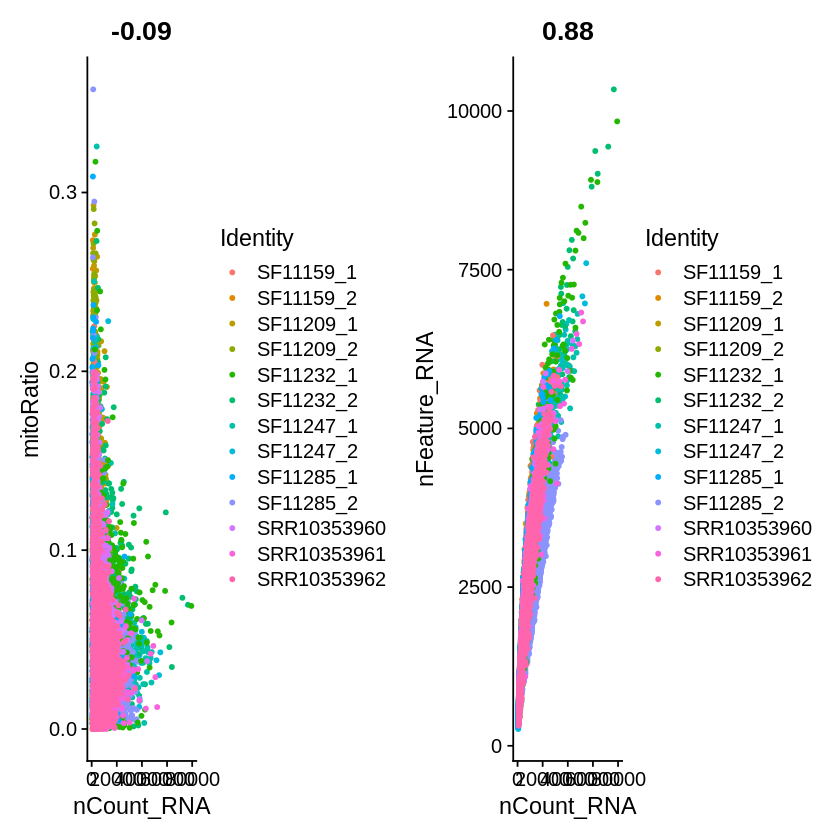

png 
  2

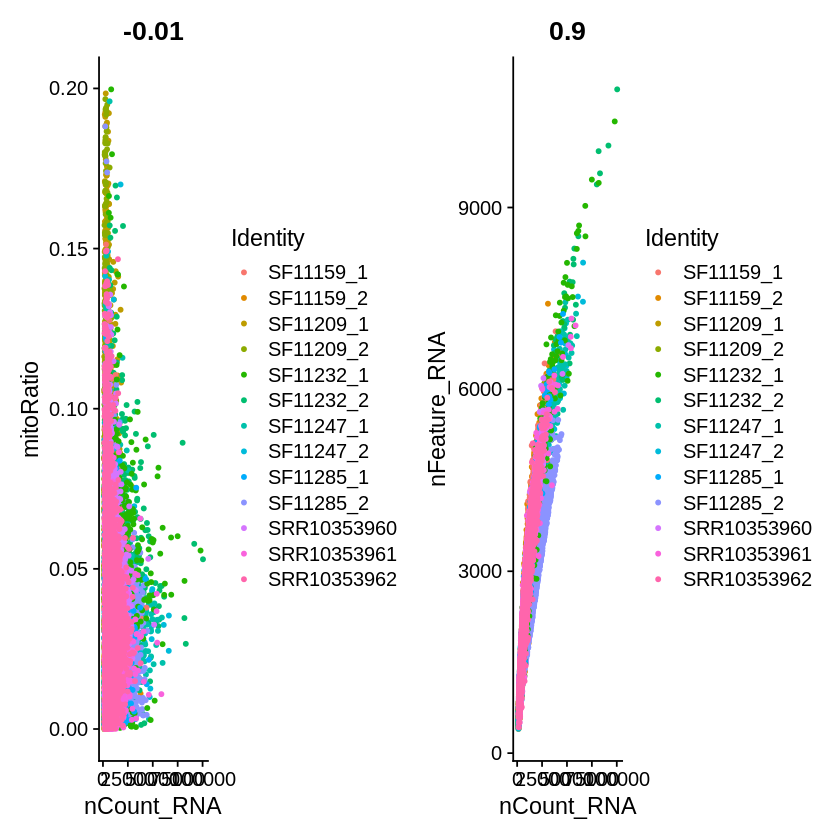

In [76]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

p <- FeatureScatter(gbmsc_ge, feature1 = "nCount_RNA", feature2 = "mitoRatio", group.by = "sample") 
p2 <- FeatureScatter(gbmsc_ge, feature1 = "nCount_RNA", feature2 = "nFeature_RNA", group.by = "sample")
p + p2
p3 <- FeatureScatter(gbmsc_gte, feature1 = "nCount_RNA", feature2 = "mitoRatio", group.by = "sample") 
p4 <- FeatureScatter(gbmsc_gte, feature1 = "nCount_RNA", feature2 = "nFeature_RNA", group.by = "sample")
p3 + p4

# Save figures
size = 7
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc-v2_FeatureScatter.pdf", 
    width = size*2, height = size*1)
grid.arrange(p,p2, nrow=1, 
             top = "Removed SF11215, min.features=1000, min.cells=30\nGBM + Neuroblastoma samples\nhg38")
grid.arrange(p3,p4, nrow =1,
             top = "Removed SF11215, min.features=1000, min.cells=30\nGBM + Neuroblastoma samples\nhg38+Retrotransposons")
dev.off()

Both violin plots and feature scatter plot show that outliers needed to be removed around 8000 genes per cell threshold.

In [79]:
gbmscfilt_ge <- subset(x = gbmsc_ge, subset= (nGene >= 300) & (nGene <= 8000) & (mitoRatio < 0.20) )

In [81]:
barcode <- colnames(gbmscfilt_ge)
gbmscfilt_gte <- subset(gbmsc_gte, cells=barcode)
dim(gbmscfilt_ge) # 45156 cells
dim(gbmscfilt_gte) # 45156 cells, around 1000 more genes than filt_ge_gbmsc which consists of Retrotransposons

dim(gbmsc_ge)[2] - dim(gbmscfilt_ge)[2] # filtered out 219 cells
dim(gbmsc_gte)[2] - dim(gbmscfilt_gte)[2] # filtered out 219 cells

[1] 22050 45156

[1] 23125 45156

[1] 219

[1] 219

In [82]:
## Save newly created objects
mkdirToday()
save(gbmscfilt_ge, file="~/scratch/gete-gbm/results/2021-08-02/gbmscfilt_ge.RData")
save(gbmscfilt_gte, file="~/scratch/gete-gbm/results/2021-08-02/gbmscfilt_gte.RData")

[1] "Current working directory: /scratch/samkyy/gete-gbm/results/2021-08-02"


Warning message in dir.create(file.path(maindir, subdir)):
"'/home/samkyy/scratch/gete-gbm/results//2021-08-02' already exists"


[1] "New working directory: /scratch/samkyy/gete-gbm/results/2021-08-02"


## Integration (v2)
2021-08-02:

In [5]:
## Save newly created objects
load("~/scratch/gete-gbm/results/2021-08-02/gbmscfilt_ge.RData")
load("~/scratch/gete-gbm/results/2021-08-02/gbmscfilt_gte.RData")

In [6]:
intObjects <- mostVariableFeatures(s_obj = list(gbmscfilt_ge, gbmscfilt_gte), meta.group = "sample")

Number of seurat objects:  2 
Splitting seurat objects by sample 


Centering and scaling data matrix



Normalize object:  1 by sample 
Processing sample : 1 
Processing sample : 2 
Processing sample : 3 
Processing sample : 4 
Processing sample : 5 
Processing sample : 6 
Processing sample : 7 
Processing sample : 8 
Processing sample : 9 
Processing sample : 10 
Processing sample : 11 
Processing sample : 12 
Processing sample : 13 


Centering and scaling data matrix



Normalize object:  2 by sample 
Processing sample : 1 
Processing sample : 2 
Processing sample : 3 
Processing sample : 4 
Processing sample : 5 
Processing sample : 6 
Processing sample : 7 
Processing sample : 8 
Processing sample : 9 
Processing sample : 10 
Processing sample : 11 
Processing sample : 12 
Processing sample : 13 


Number of seurat objects:  2 


Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 1705 rows containing missing values (geom_point)."


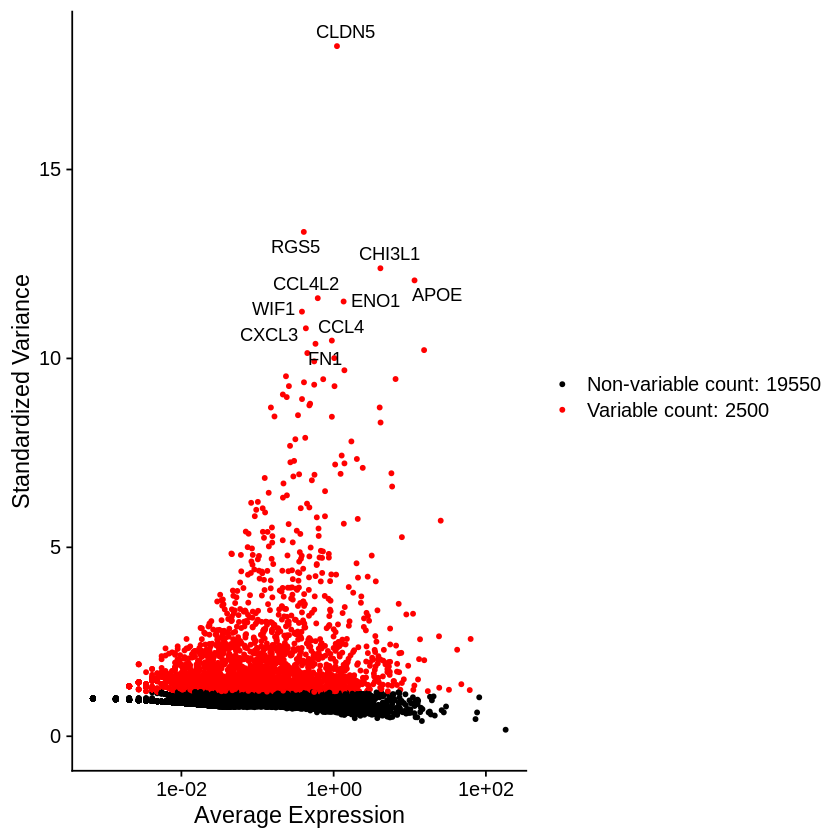

In [84]:
p <- top10VarFeatures(intObjects)
p[[1]][[1]]

In [85]:
length(p)
length(p[[1]])

[1] 2

[1] 13

In [86]:
# Save figures
size = 7
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc-v2_ge_top10VariableFeaturesbySample.pdf", 
    width = size*5, height = size*2)
grid.arrange(p[[1]][[1]], p[[1]][[2]],p[[1]][[3]], p[[1]][[4]], p[[1]][[5]],
             p[[1]][[6]], p[[1]][[7]],p[[1]][[8]], p[[1]][[9]], p[[1]][[10]],
             p[[1]][[11]], p[[1]][[12]],p[[1]][[13]],nrow=3, 
             top = "GBM + Neuroblastoma samples (v2)\nhg38")
dev.off()

pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc-v2_gte_top10VariableFeaturesbySample.pdf", 
    width = size*5, height = size*2)
grid.arrange(p[[2]][[1]], p[[2]][[2]],p[[2]][[3]], p[[2]][[4]], p[[2]][[5]],
             p[[2]][[6]], p[[2]][[7]],p[[2]][[8]], p[[2]][[9]], p[[2]][[10]],
             p[[2]][[11]], p[[2]][[12]],p[[2]][[13]],nrow=3, 
             top = "GBM + Neuroblastoma samples (v2)\nhg38 + Retrotransposons")
dev.off()

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 1705 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 2168 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 2129 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 472 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 1493 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 363 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infi

png 
  2

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 1720 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 2184 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 2138 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 475 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 1515 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 365 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infi

png 
  2

The variable feature plots look acceptable (no samples with most variable features being mitochondrial genes). 

Procede to integration

In [7]:
intObjects <- integrateObjects(s_list = intObjects, folderDate = "2021-08-02", nDims = 25)

Number of seurat objects:  2 
Results Folder Date:  2021-08-02 
Results number of dimensions:  25 
Integrating seurat object:  1 
Number of samples in this seurat object 13 


Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3827 anchors

Filtering anchors

	Retained 2096 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3893 anchors

Filtering anchors

	Retained 2217 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4225 anchors

Filtering anchors

	Retained 3106 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5305 anchors

Filtering anchors

	Retained 1932 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5915 anchors

Filtering anchors

	Retained 2037 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6032 anchors

Filtering anchors

	Retained 2164 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2055 anchors


Finding anchors

	Found 11145 anchors

Filtering anchors

	Retained 4023 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4679 anchors

Filtering anchors

	Retained 1578 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 10340 anchors

Filtering anchors

	Retained 1841 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2081 anchors

Filtering anchors

	Retained 1070 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12712 anchors

Filtering anchors

	Retained 3797 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 10469 anchors

Filtering anchors

	Retained 3447 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4972 anchors

Filtering anchors

	Retained 2059 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5444 anchors

Filtering anchors

	

Object # 1 Saved
Integrating seurat object:  2 
Number of samples in this seurat object 13 


Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3770 anchors

Filtering anchors

	Retained 1983 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3772 anchors

Filtering anchors

	Retained 2088 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4202 anchors

Filtering anchors

	Retained 3265 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5252 anchors

Filtering anchors

	Retained 1884 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5890 anchors

Filtering anchors

	Retained 2052 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6041 anchors

Filtering anchors

	Retained 2108 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2071 anchors


Finding anchors

	Found 11072 anchors

Filtering anchors

	Retained 4250 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4643 anchors

Filtering anchors

	Retained 1404 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 10206 anchors

Filtering anchors

	Retained 1740 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2099 anchors

Filtering anchors

	Retained 978 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12644 anchors

Filtering anchors

	Retained 3934 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 10290 anchors

Filtering anchors

	Retained 3444 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4966 anchors

Filtering anchors

	Retained 2257 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5413 anchors

Filtering anchors

	R

Object # 2 Saved


In [8]:
file.rename(from=c("~/scratch/gete-gbm/results/2021-08-02/temp_1.rds",
                  "~/scratch/gete-gbm/results/2021-08-02/temp_2.rds"), 
           to = c("~/scratch/gete-gbm/results/2021-08-02/gbmscGEint-v2.rds",
                 "~/scratch/gete-gbm/results/2021-08-02/gbmscGTEint-v2.rds"))

[1] TRUE TRUE

## PCA (post-filtering)
2021-08-02:

In [10]:
intObjects <- vector(mode="list", length=2)
intObjects[[1]]<- readRDS("~/scratch/gete-gbm/results/2021-08-02/gbmscGEint-v2.rds")
intObjects[[2]]<- readRDS("~/scratch/gete-gbm/results/2021-08-02/gbmscGTEint-v2.rds")

In [11]:
names(intObjects) <- c("GE", "GTE")

In [12]:
# specify that we will perform downstream analysis on the corrected data note that the original
# unmodified data still resides in the 'RNA' assay
DefaultAssay(intObjects[[1]]) <- "integrated"
DefaultAssay(intObjects[[2]]) <- "integrated"

In [13]:
# Run the standard workflow for visualization and clustering (ScaleData, RunPCA, RunUMAP, FindNeighbors, FindClusters)
intObjects[[1]] <- ScaleData(object = intObjects[[1]], verbose = FALSE)
intObjects[[2]] <- ScaleData(object = intObjects[[2]], verbose = FALSE)

In [14]:
# Run PCA and UMAP ~10min 
intObjects[[1]] <- RunPCA(object = intObjects[[1]], npcs = 25, verbose = FALSE)

# Run PCA and UMAP ~10min
intObjects[[2]] <- RunPCA(object = intObjects[[2]], npcs = 25, verbose = FALSE)

In [15]:
save(intObjects,file="~/scratch/gete-gbm/results/2021-08-02/gbmsc-v2_ge_gte_PCA.RData")

In [16]:
print("steps up to PCA completed")

[1] "steps up to PCA completed"


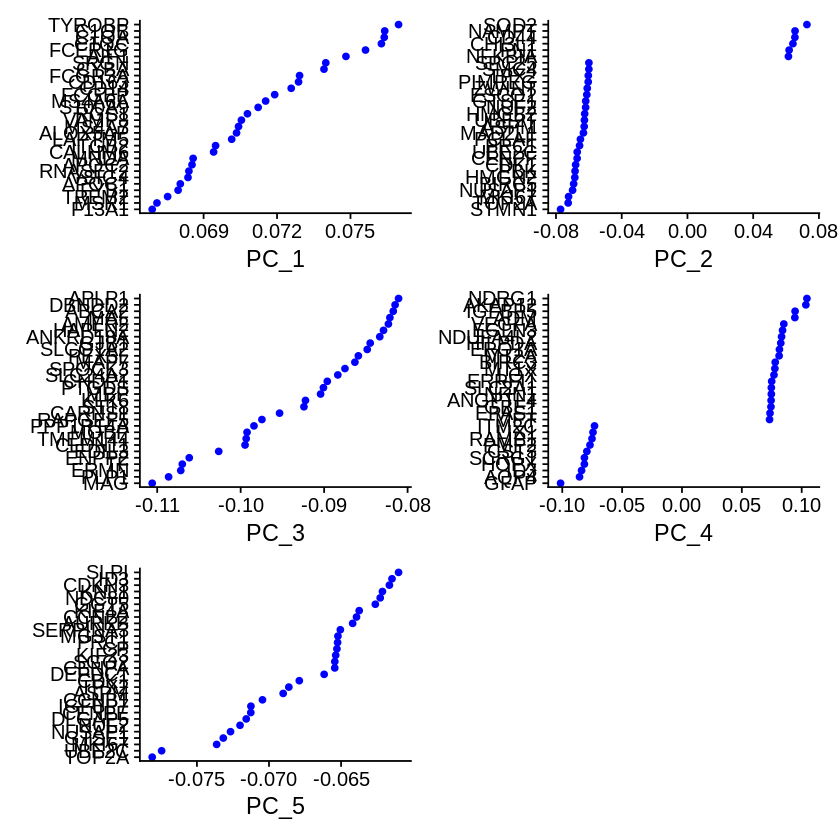

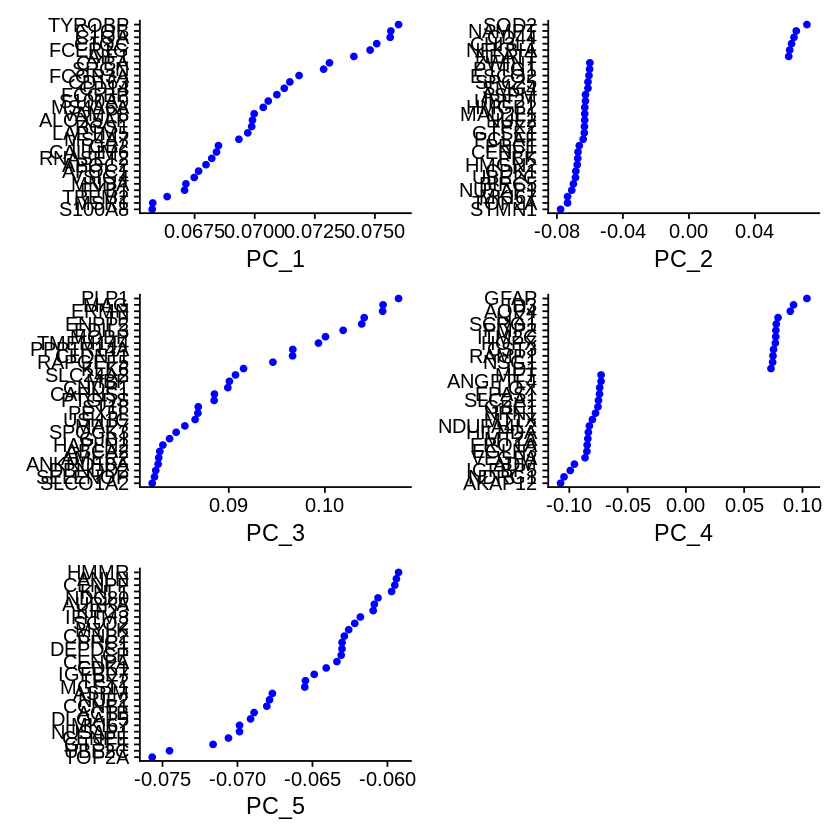

In [17]:
VizDimLoadings(intObjects[[1]], dims = 1:5, reduction = "pca")
VizDimLoadings(intObjects[[2]], dims = 1:5, reduction = "pca")

In [18]:
## Heatmaps for each PC (GE)
size <- 7
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc-v2_ge_PCHeatmaps.pdf", 
    width = size*3, height = size*7)
DimHeatmap(intObjects[[1]], dims = 1:25, cells = 1000, balanced = TRUE, ncol=3, combine = FALSE)
dev.off()

png 
  2

In [19]:
## Heatmaps for each PC (GTE)
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc-v2_gte_PCHeatmaps.pdf", 
    width = size*3, height = size*7)
DimHeatmap(intObjects[[2]], dims = 1:25, cells = 1000, balanced = TRUE, ncol=3, combine = FALSE)
dev.off()

png 
  2

In [20]:
# Which PCAs should we include in our analyses? 
p <- ElbowPlot(object = intObjects[[1]], ndims = 25) 
p2 <- ElbowPlot(object = intObjects[[2]], ndims = 25)

pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc-v2_ge_gte_PCElbowPlots.pdf", 
    width = size*2, height = size)
grid.arrange(p, p2, nrow=1, 
             top = "GBM + Neuroblastoma samples (version 2)")
dev.off()

png 
  2

Warning message:
"Removed 35000 rows containing missing values (geom_point)."
Warning message:
"Removed 35000 rows containing missing values (geom_point)."


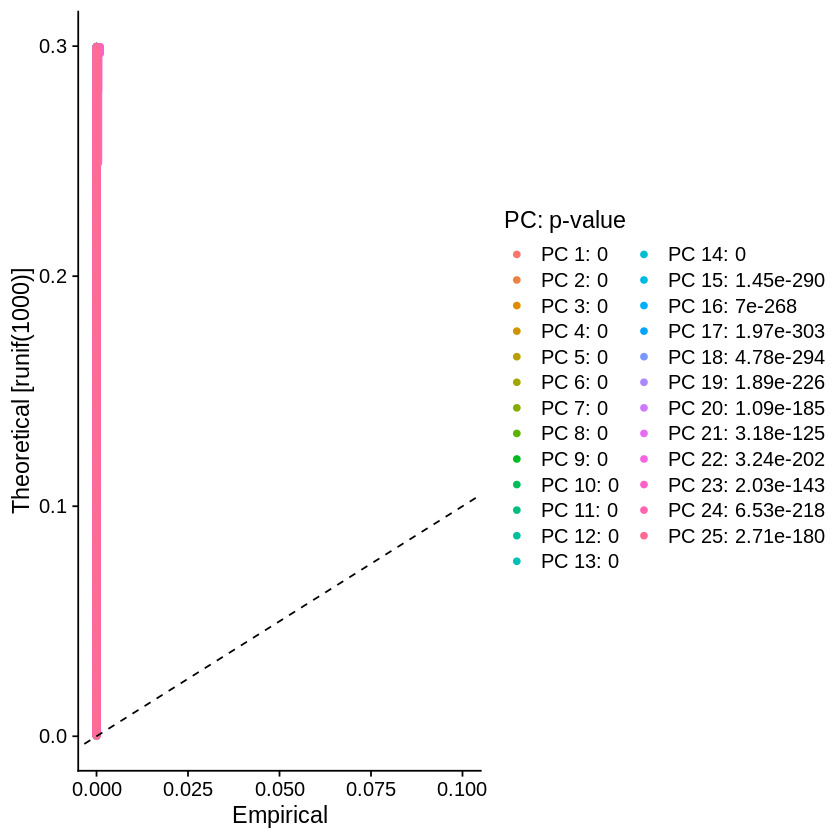

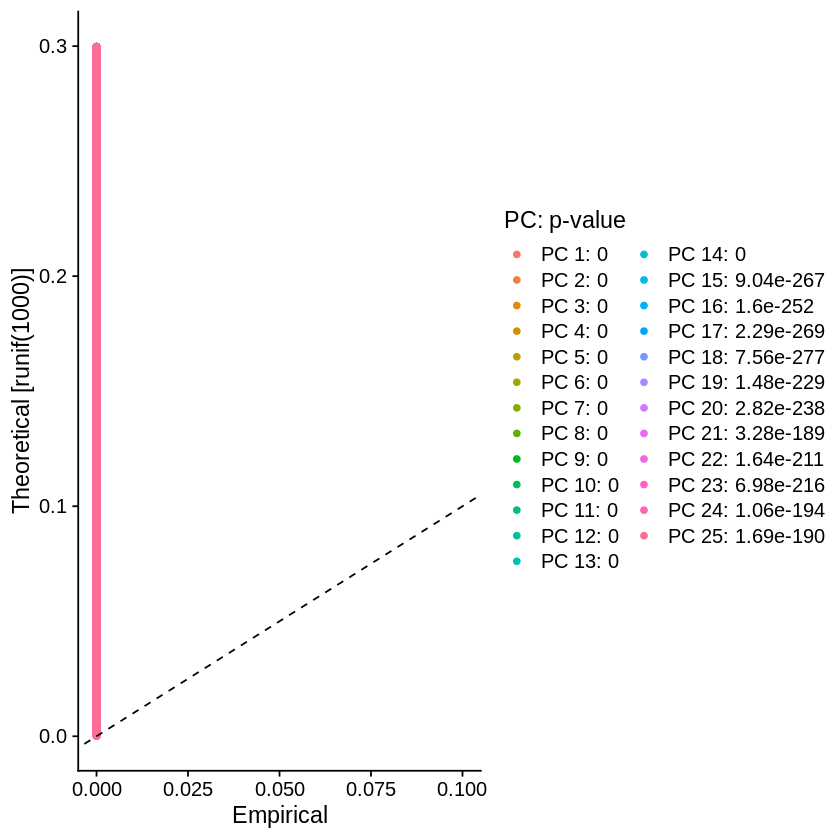

In [7]:
# NOTE: This process can take a long time for big datasets, comment out for expediency. More
# approximate techniques such as those implemented in ElbowPlot() can be used to reduce
# computation time
jackPlots <- vector(mode="list", length=2)
jackPlots[[1]] <- JackStraw(intObjects[[1]], num.replicate = 100, dims = 25)
jackPlots[[1]] <- ScoreJackStraw(jackPlots[[1]], dims = 1:25)
JackStrawPlot(jackPlots[[1]], dims = 1:25)
# NOTE: This process can take a long time for big datasets, comment out for expediency. More
# approximate techniques such as those implemented in ElbowPlot() can be used to reduce
# computation time
jackPlots[[2]] <- JackStraw(intObjects[[2]], num.replicate = 100, dims = 25)
jackPlots[[2]] <- ScoreJackStraw(jackPlots[[2]], dims = 1:25)
JackStrawPlot(jackPlots[[2]], dims = 1:25)

Warning message:
"Removed 2500 rows containing missing values (geom_point)."
Warning message:
"Removed 2500 rows containing missing values (geom_point)."


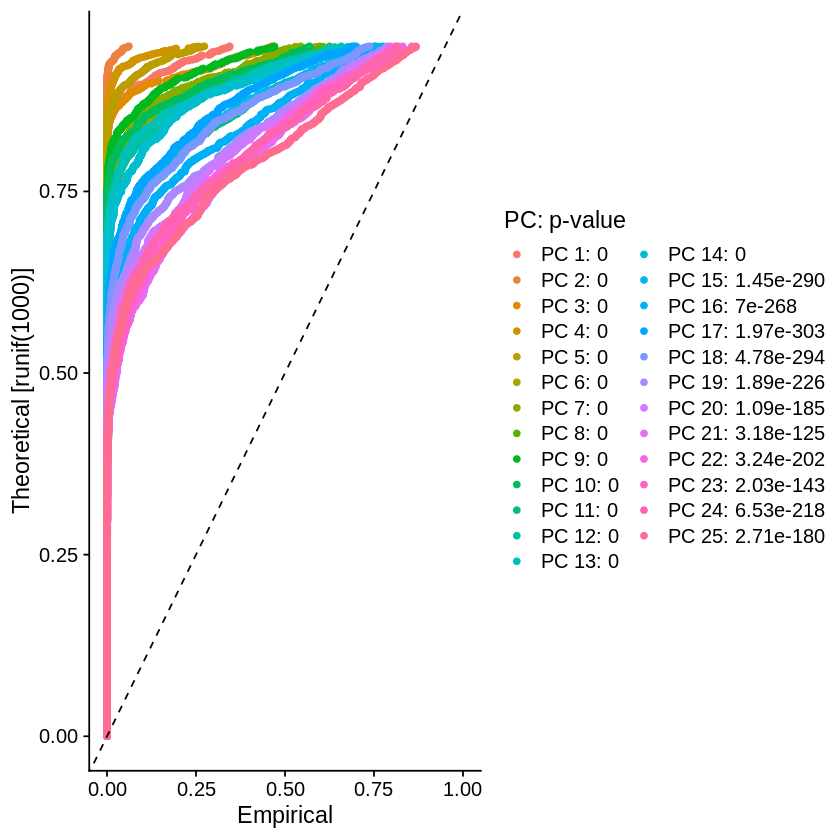

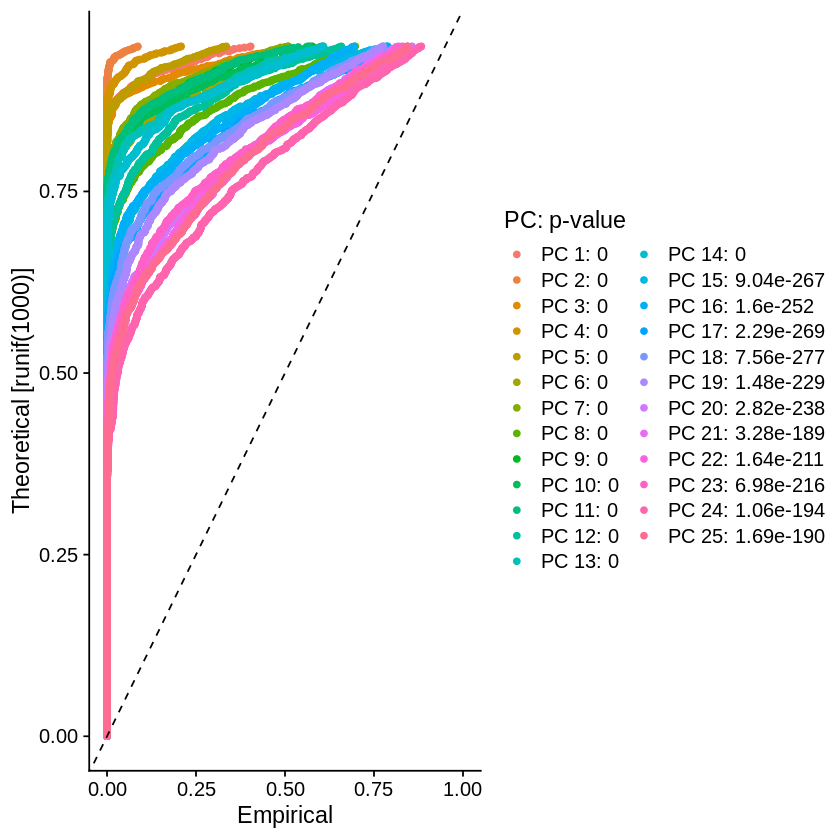

In [11]:
JackStrawPlot(jackPlots[[1]], dims = 1:25, xmax = 1.0,ymax = 0.95)
JackStrawPlot(jackPlots[[2]], dims = 1:25, xmax = 1.0,ymax = 0.95)

In [13]:
p <- JackStrawPlot(jackPlots[[1]], dims = 1:25, xmax = 1.0,ymax = 0.95)
p2 <- JackStrawPlot(jackPlots[[2]], dims = 1:25, xmax = 1.0,ymax = 0.95)

size <- 7
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc-v2_ge_gte_PCJackStraw.pdf", 
    width = size*4, height = size*1.5)
grid.arrange(p, p2, nrow=1, 
             top = "JackStraw Plots of GBM + Neuroblastoma samples (vers. 2)")
dev.off()

Warning message:
"Removed 2500 rows containing missing values (geom_point)."
Warning message:
"Removed 2500 rows containing missing values (geom_point)."


png 
  2

In [22]:
# Determine percent of variation associated with each PC
pct <- intObjects[[1]][["pca"]]@stdev / sum(intObjects[[1]][["pca"]]@stdev) * 100

# Calculate cumulative percents for each PC
cumu <- cumsum(pct)

# Determine which PC exhibits cumulative percent greater than 90% and % variation associated with the PC as less than 5
co1 <- which(cumu > 90 & pct < 5)[1]

co1

# Determine the difference between variation of PC and subsequent PC
co2 <- sort(which((pct[1:length(pct) - 1] - pct[2:length(pct)]) > 0.1), decreasing = T)[1] + 1

# last point where change of % of variation is more than 0.1%.
co2

# Minimum of the two calculation
pcs <- min(co1, co2)

pcs

[1] 20

[1] 19

[1] 19

In [23]:
# Determine percent of variation associated with each PC
pct <- intObjects[[2]][["pca"]]@stdev / sum(intObjects[[2]][["pca"]]@stdev) * 100

# Calculate cumulative percents for each PC
cumu <- cumsum(pct)

# Determine which PC exhibits cumulative percent greater than 90% and % variation associated with the PC as less than 5
co1 <- which(cumu > 90 & pct < 5)[1]

co1

# Determine the difference between variation of PC and subsequent PC
co2 <- sort(which((pct[1:length(pct) - 1] - pct[2:length(pct)]) > 0.1), decreasing = T)[1] + 1

# last point where change of % of variation is more than 0.1%.
co2

# Minimum of the two calculation
pcs <- min(co1, co2)

pcs

[1] 20

[1] 20

[1] 20

## UMAP
- 2021-07-28: wrote scripts
- 2021-08-03: Performed analysis with intObjects (gbmsc-v2_ge_gte_PCA.RData)

In [5]:
load("~/scratch/gete-gbm/results/2021-08-02/gbmsc-v2_ge_gte_PCA.RData")

In [6]:
## Set of Principle Components to use for UMAP analysis
pc <- c(12:21)
pc
length(pc) ## We will be testing 10 PCs

[1] 12 13 14 15 16 17 18 19 20 21

[1] 10

In [7]:
## Perform UMAP analysis
ge_umaps <- vector(mode="list", length=length(pc))
gte_umaps <- vector(mode="list", length=length(pc))

names(ge_umaps) <- as.character(pc)
names(gte_umaps) <- as.character(pc)

for (i in 1:length(pc)){
    ge_umaps[[i]] <- RunUMAP(object = intObjects[[1]], 
                                 reduction = "pca", dims = 1:pc[i], umap.method = "uwot", metric = "cosine")
    gte_umaps[[i]] <- RunUMAP(object = intObjects[[2]], 
                                 reduction = "pca", dims = 1:pc[i], umap.method = "uwot", metric = "cosine")
}

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
16:31:46 UMAP embedding parameters a = 0.9922 b = 1.112

16:31:47 Read 45156 rows and found 12 numeric columns

16:31:47 Using Annoy for neighbor search, n_neighbors = 30

16:31:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:31:55 Writing NN index file to temp file /tmp/Rtmpp6WVRn/file279512c2e02b

16:31:55 Searching Annoy index using 1 thread, search_k = 3000

16:32:20 Annoy recall = 100%

16:32:22 Commencing smooth kNN distance calibration using 1 thread

16:32:26 Initializing fr

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:44:03 Writing NN index file to temp file /tmp/Rtmpp6WVRn/file279565eeafb

16:44:03 Searching Annoy index using 1 thread, search_k = 3000

16:44:25 Annoy recall = 100%

16:44:26 Commencing smooth kNN distance calibration using 1 thread

16:44:30 Initializing from normalized Laplacian + noise

16:44:36 Commencing optimization for 200 epochs, with 1957144 positive edges

16:45:13 Optimization finished

16:45:13 UMAP embedding parameters a = 0.9922 b = 1.112

16:45:13 Read 45156 rows and found 17 numeric columns

16:45:13 Using Annoy for neighbor search, n_neighbors = 30

16:45:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

16:56:13 Commencing optimization for 200 epochs, with 2021878 positive edges

16:56:50 Optimization finished

16:56:50 UMAP embedding parameters a = 0.9922 b = 1.112

16:56:50 Read 45156 rows and found 21 numeric columns

16:56:50 Using Annoy for neighbor search, n_neighbors = 30

16:56:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:56:57 Writing NN index file to temp file /tmp/Rtmpp6WVRn/file27957aba9fe3

16:56:57 Searching Annoy index using 1 thread, search_k = 3000

16:57:18 Annoy recall = 100%

16:57:19 Commencing smooth kNN distance calibration using 1 thread

16:57:23 Initializing from normalized Laplacian + noise

16:57:31 Commencing optimization for 200 epochs, with 2008552 positive edges

16:58:08 Optimization finished



In [8]:
## Find Neighbors
for (i in 1:length(pc)) {
    # Determine the K-nearest neighbor graph
    ge_umaps[[i]] <- FindNeighbors(ge_umaps[[i]],dims=1:pc[[i]],reduction="pca")
    gte_umaps[[i]] <- FindNeighbors(gte_umaps[[i]],dims=1:pc[[i]],reduction="pca")
}

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN

Computing nearest neighbor graph

Computing SNN



In [9]:
res <- c(0.2, 0.4, 0.6, 0.8, 1.0, 1.2)

# Find Clusters with a vector of resolutions
for (i in 1:length(ge_umaps)) { ## Compute clusters for each separate umap 
    for (j in 1:length(res)) { ## Compute for each resolution
        ge_umaps[[i]] <- FindClusters(ge_umaps[[i]], resolution = res[j])
        gte_umaps[[i]] <- FindClusters(gte_umaps[[i]], resolution = res[j])
    }
}

# You can view different resolutions using:
# Idents(object = filt_gte_brain.intergrated) <- "integrated_snn_res.0.8"

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 45156
Number of edges: 1558175

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9444
Number of communities: 10
Elapsed time: 15 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 45156
Number of edges: 1525541

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9391
Number of communities: 11
Elapsed time: 16 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 45156
Number of edges: 1558175

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9216
Number of communities: 16
Elapsed time: 13 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 45156
Number of edges: 1525541

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9155
Number of communities: 18
Elapsed time: 13 seconds
Modu

Evaluate umaps at the lowest resolution to observe clustering. I'm expecting around 4-5 clusters in these samples. 

In [15]:
p <- vector(mode="list", length=length(ge_umaps))

for (i in 1:length(ge_umaps)) {
    Idents(object = ge_umaps[[i]]) <- "integrated_snn_res.0.2"
    Idents(object = gte_umaps[[i]]) <- "integrated_snn_res.0.2"

    p[[i]][[1]] <- DimPlot(ge_umaps[[i]], reduction = "umap", group.by = "sample") + ggtitle("hg38 by Sample Origin")
    p[[i]][[2]] <- DimPlot(ge_umaps[[i]], reduction = "umap", label = TRUE, repel = TRUE) + ggtitle("hg38 by Clusters")

    p[[i]][[3]] <- DimPlot(gte_umaps[[i]], reduction = "umap", group.by = "sample") + ggtitle("hg38 by Sample Origin")
    p[[i]][[4]] <- DimPlot(gte_umaps[[i]], reduction = "umap", label = TRUE, repel = TRUE) + ggtitle("hg38 + Retrotransposons by Clusters")
}

In [16]:
# Save figures
size = 7
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC12_r02.pdf", width = size*2, height = size*2)
grid.arrange(p[[1]][[1]], p[[1]][[2]], 
             p[[1]][[3]], p[[1]][[4]], nrow=2, top = "UMAP PC12 resolution 0.2")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC13_r02.pdf", width = size*2, height = size*2)
grid.arrange(p[[2]][[1]], p[[2]][[2]], 
             p[[2]][[3]], p[[2]][[4]], nrow=2, top = "UMAP PC13 resolution 0.2")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC14_r02.pdf", width = size*2, height = size*2)
grid.arrange(p[[3]][[1]], p[[3]][[2]], 
             p[[3]][[3]], p[[3]][[4]], nrow=2, top = "UMAP PC14 resolution 0.2")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC15_r02.pdf", width = size*2, height = size*2)
grid.arrange(p[[4]][[1]], p[[4]][[2]], 
             p[[4]][[3]], p[[4]][[4]], nrow=2, top = "UMAP PC15 resolution 0.2")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC16_r02.pdf", width = size*2, height = size*2)
grid.arrange(p[[5]][[1]], p[[5]][[2]], 
             p[[5]][[3]], p[[5]][[4]], nrow=2, top = "UMAP PC16 resolution 0.2")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC17_r02.pdf", width = size*2, height = size*2)
grid.arrange(p[[6]][[1]], p[[6]][[2]], 
             p[[6]][[3]], p[[6]][[4]], nrow=2, top = "UMAP PC17 resolution 0.2")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC18_r02.pdf", width = size*2, height = size*2)
grid.arrange(p[[7]][[1]], p[[7]][[2]], 
             p[[7]][[3]], p[[7]][[4]], nrow=2, top = "UMAP PC18 resolution 0.2")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC19_r02.pdf", width = size*2, height = size*2)
grid.arrange(p[[8]][[1]], p[[8]][[2]], 
             p[[8]][[3]], p[[8]][[4]], nrow=2, top = "UMAP PC19 resolution 0.2")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC20_r02.pdf", width = size*2, height = size*2)
grid.arrange(p[[9]][[1]], p[[9]][[2]], 
             p[[9]][[3]], p[[9]][[4]], nrow=2, top = "UMAP PC20 resolution 0.2")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC21_r02.pdf", width = size*2, height = size*2)
grid.arrange(p[[10]][[1]], p[[10]][[2]], 
             p[[10]][[3]], p[[10]][[4]], nrow=2, top = "UMAP PC21 resolution 0.2")
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

Moving forward with evaluating resolution of the UMAP for cluster subtypes, I will continue my analysis using PC14, 16, 17, 19 and 20.

In [32]:
pc_select <- c("14", "16", "17", "19", "20")

p <- vector(mode="list", length=length(pc_select))

for (i in 1:length(pc_select)) {
    Idents(object = ge_umaps[[pc_select[i]]]) <- "integrated_snn_res.0.4"
    Idents(object = gte_umaps[[pc_select[i]]]) <- "integrated_snn_res.0.4"

    p[[i]][[1]] <- DimPlot(ge_umaps[[pc_select[i]]], reduction = "umap", label = TRUE, repel = TRUE) + ggtitle("hg38 by Clusters")
    p[[i]][[2]] <- DimPlot(gte_umaps[[pc_select[i]]], reduction = "umap", label = TRUE, repel = TRUE) + ggtitle("hg38 + Retrotransposons by Clusters")
}

In [33]:
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC14_r04.pdf", width = size*2.5, height = size*1)
grid.arrange(p[[1]][[1]], p[[1]][[2]], nrow=1, top = "UMAP PC14 resolution 0.4")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC16_r04.pdf", width = size*2.5, height = size*1)
grid.arrange(p[[2]][[1]], p[[2]][[2]], nrow=1, top = "UMAP PC16 resolution 0.4")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC17_r04.pdf", width = size*2.5, height = size*1)
grid.arrange(p[[3]][[1]], p[[3]][[2]], nrow=1, top = "UMAP PC17 resolution 0.4")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC19_r04.pdf", width = size*2.5, height = size*1)
grid.arrange(p[[4]][[1]], p[[4]][[2]], nrow=1, top = "UMAP PC19 resolution 0.4")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC20_r04.pdf", width = size*2.5, height = size*1)
grid.arrange(p[[5]][[1]], p[[5]][[2]], nrow=1, top = "UMAP PC20 resolution 0.4")
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

In [34]:
pc_select <- c("14", "16", "17", "19", "20")

p <- vector(mode="list", length=length(pc_select))

for (i in 1:length(pc_select)) {
    Idents(object = ge_umaps[[pc_select[i]]]) <- "integrated_snn_res.0.6"
    Idents(object = gte_umaps[[pc_select[i]]]) <- "integrated_snn_res.0.6"

    p[[i]][[1]] <- DimPlot(ge_umaps[[pc_select[i]]], reduction = "umap", label = TRUE, repel = TRUE) + ggtitle("hg38 by Clusters")
    p[[i]][[2]] <- DimPlot(gte_umaps[[pc_select[i]]], reduction = "umap", label = TRUE, repel = TRUE) + ggtitle("hg38 + Retrotransposons by Clusters")
}

In [35]:
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC14_r06.pdf", width = size*2.5, height = size*1)
grid.arrange(p[[1]][[1]], p[[1]][[2]], nrow=1, top = "UMAP PC14 resolution 0.6")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC16_r06.pdf", width = size*2.5, height = size*1)
grid.arrange(p[[2]][[1]], p[[2]][[2]], nrow=1, top = "UMAP PC16 resolution 0.6")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC17_r06.pdf", width = size*2.5, height = size*1)
grid.arrange(p[[3]][[1]], p[[3]][[2]], nrow=1, top = "UMAP PC17 resolution 0.6")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC19_r06.pdf", width = size*2.5, height = size*1)
grid.arrange(p[[4]][[1]], p[[4]][[2]], nrow=1, top = "UMAP PC19 resolution 0.6")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC20_r06.pdf", width = size*2.5, height = size*1)
grid.arrange(p[[5]][[1]], p[[5]][[2]], nrow=1, top = "UMAP PC20 resolution 0.6")
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

In [36]:
pc_select <- c("14", "16", "17", "19", "20")

p <- vector(mode="list", length=length(pc_select))

for (i in 1:length(pc_select)) {
    Idents(object = ge_umaps[[pc_select[i]]]) <- "integrated_snn_res.0.8"
    Idents(object = gte_umaps[[pc_select[i]]]) <- "integrated_snn_res.0.8"

    p[[i]][[1]] <- DimPlot(ge_umaps[[pc_select[i]]], reduction = "umap", label = TRUE, repel = TRUE) + ggtitle("hg38 by Clusters")
    p[[i]][[2]] <- DimPlot(gte_umaps[[pc_select[i]]], reduction = "umap", label = TRUE, repel = TRUE) + ggtitle("hg38 + Retrotransposons by Clusters")
}

In [37]:
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC14_r08.pdf", width = size*2.5, height = size*1)
grid.arrange(p[[1]][[1]], p[[1]][[2]], nrow=1, top = "UMAP PC14 resolution 0.8")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC16_r08.pdf", width = size*2.5, height = size*1)
grid.arrange(p[[2]][[1]], p[[2]][[2]], nrow=1, top = "UMAP PC16 resolution 0.8")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC17_r08.pdf", width = size*2.5, height = size*1)
grid.arrange(p[[3]][[1]], p[[3]][[2]], nrow=1, top = "UMAP PC17 resolution 0.8")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC19_r08.pdf", width = size*2.5, height = size*1)
grid.arrange(p[[4]][[1]], p[[4]][[2]], nrow=1, top = "UMAP PC19 resolution 0.8")
dev.off()
pdf("~/scratch/gete-gbm/results/2021-08-02/r_gbmsc_umaps_PC20_r08.pdf", width = size*2.5, height = size*1)
grid.arrange(p[[5]][[1]], p[[5]][[2]], nrow=1, top = "UMAP PC20 resolution 0.8")
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

In [38]:
saveRDS(ge_umaps[["14"]], file="~/scratch/gete-gbm/results/2021-08-02/gbmsc_ge-PC14.rds")
saveRDS(ge_umaps[["16"]], file="~/scratch/gete-gbm/results/2021-08-02/gbmsc_ge-PC16.rds")
saveRDS(ge_umaps[["17"]], file="~/scratch/gete-gbm/results/2021-08-02/gbmsc_ge-PC17.rds")
saveRDS(ge_umaps[["19"]], file="~/scratch/gete-gbm/results/2021-08-02/gbmsc_ge-PC19.rds")
saveRDS(ge_umaps[["20"]], file="~/scratch/gete-gbm/results/2021-08-02/gbmsc_ge-PC20.rds")

In [10]:
saveRDS(gte_umaps[["14"]], file="~/scratch/gete-gbm/results/2021-08-02/gbmsc_gte-PC14.rds")
saveRDS(gte_umaps[["16"]], file="~/scratch/gete-gbm/results/2021-08-02/gbmsc_gte-PC16.rds")
saveRDS(gte_umaps[["17"]], file="~/scratch/gete-gbm/results/2021-08-02/gbmsc_gte-PC17.rds")
saveRDS(gte_umaps[["19"]], file="~/scratch/gete-gbm/results/2021-08-02/gbmsc_gte-PC19.rds")
saveRDS(gte_umaps[["20"]], file="~/scratch/gete-gbm/results/2021-08-02/gbmsc_gte-PC20.rds")

In [11]:
rm(ge_umaps)
rm(gte_umaps)

## Exploring Known Markers
2021-08-03:

In [12]:
gbmsc_ge19 <- readRDS("~/scratch/gete-gbm/results/2021-08-02/gbmsc_ge-PC19.rds")
gbmsc_gte20 <- readRDS("~/scratch/gete-gbm/results/2021-08-02/gbmsc_gte-PC20.rds")

Map CD144 (PROM1) expressing cells

In [13]:
match(c('PROM1'), rownames(gbmsc_ge19))
match(c('PROM1'), rownames(gbmsc_gte20))

match(c('PROM1'), rownames(gbmsc_ge19@assays$RNA))
match(c('PROM1'), rownames(gbmsc_gte20@assays$RNA))

[1] NA

[1] NA

[1] 5113

[1] 5112

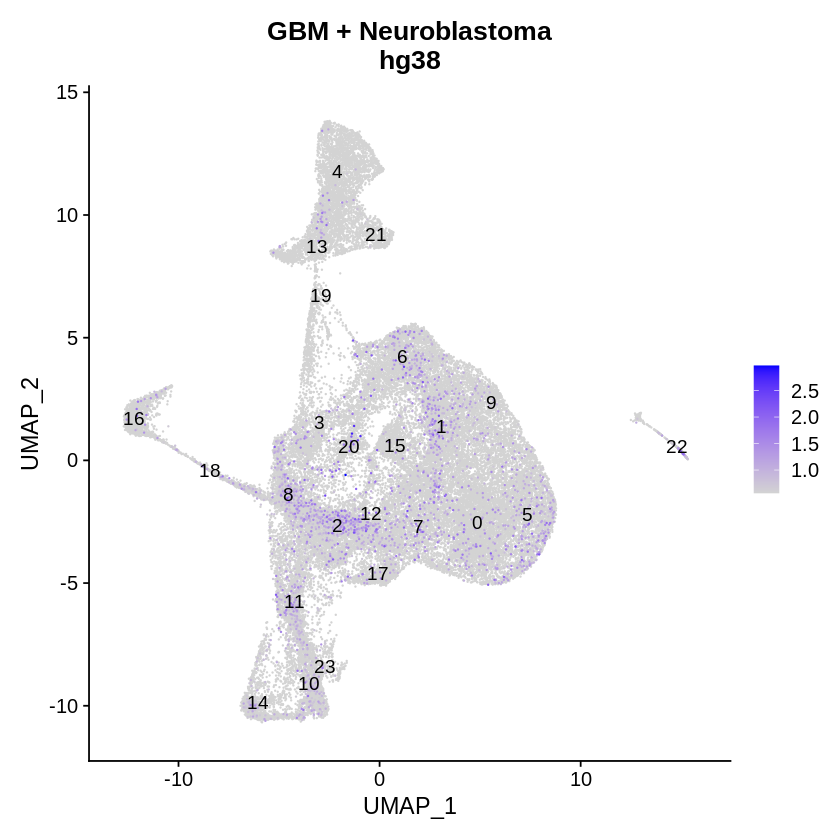

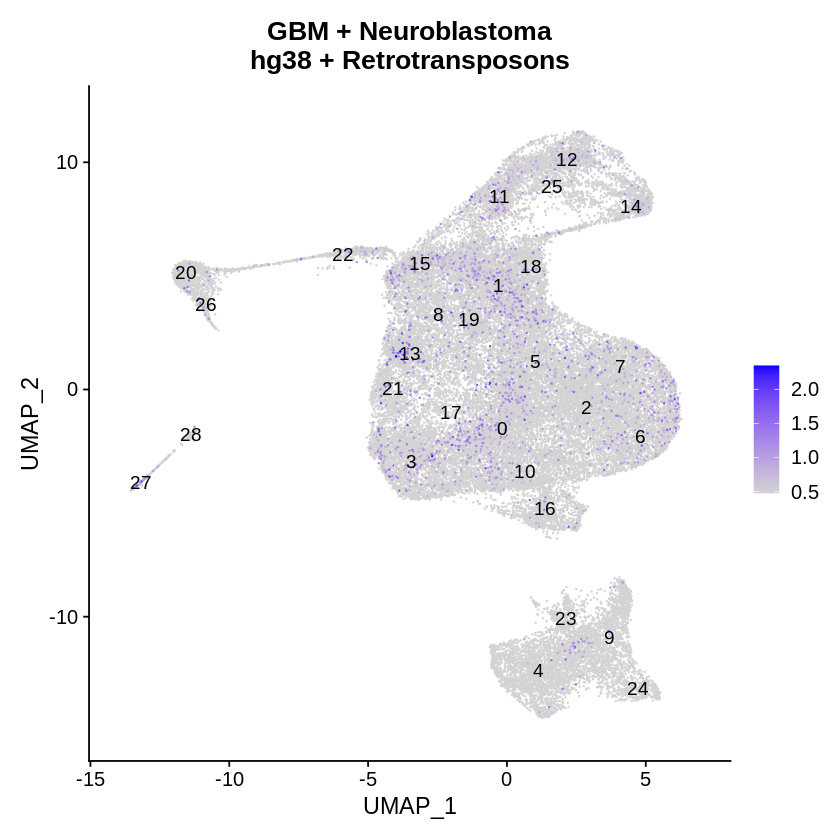

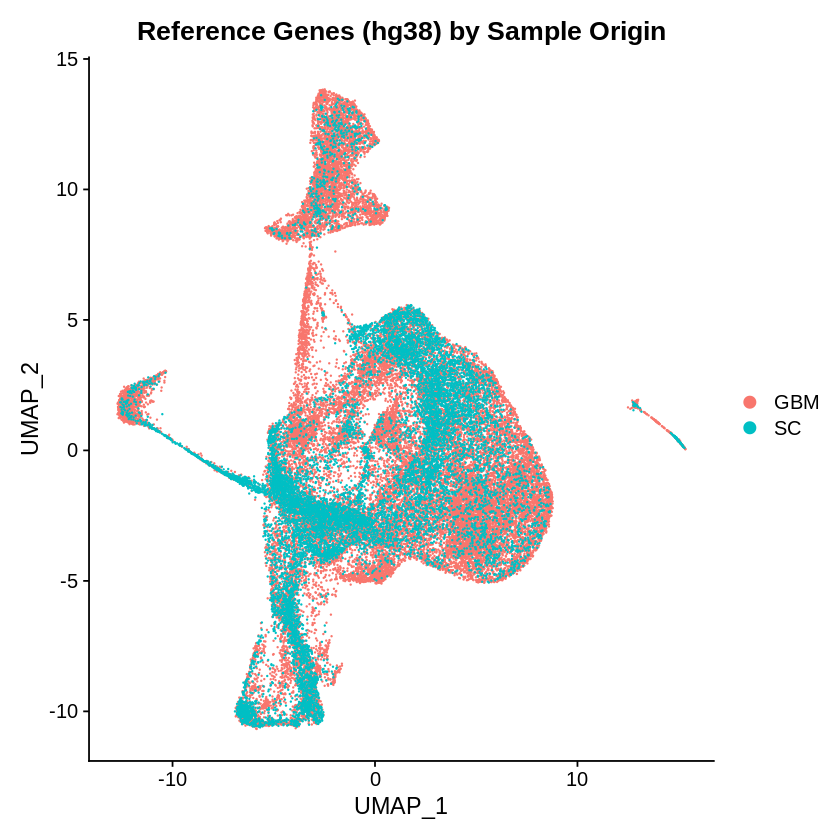

png 
  2

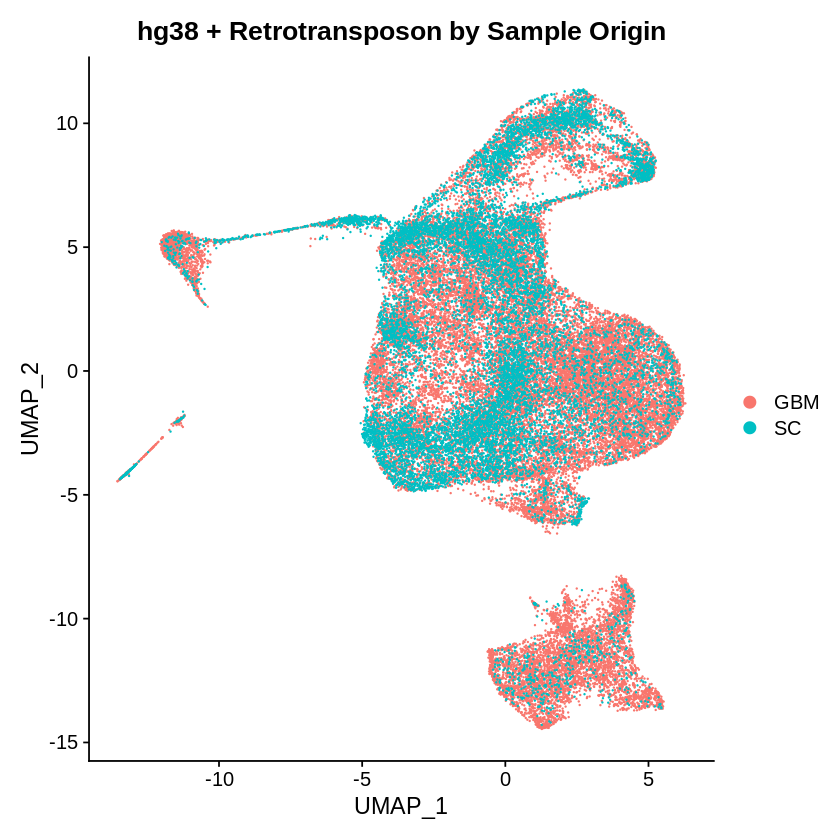

In [16]:
DefaultAssay(gbmsc_ge19) <- "RNA"
DefaultAssay(gbmsc_gte20) <- "RNA"

p1 <- FeaturePlot(gbmsc_ge19, 
            reduction = "umap", 
            features = c('PROM1'), 
            order = TRUE, #replaces sort.cell = TRUE
            min.cutoff = 'q10', #quantil
            label = TRUE) + ggtitle("GBM + Neuroblastoma\nhg38")
p2 <- FeaturePlot(gbmsc_gte20, 
            reduction = "umap", 
            features = c('PROM1'), 
            order = TRUE, #replaces sort.cell = TRUE
            min.cutoff = 'q10', #quantile
            label = TRUE) + ggtitle("GBM + Neuroblastoma\nhg38 + Retrotransposons")
p1
p2

### Show 

p3 <- DimPlot(gbmsc_ge19, reduction = "umap", group.by = "source") + ggtitle("Reference Genes (hg38) by Sample Origin")
p4 <- DimPlot(gbmsc_gte20, reduction = "umap", group.by = "source") + ggtitle("hg38 + Retrotransposon by Sample Origin")
p3
p4

# Save figures

size = 7
pdf("/home/samkyy/scratch/gete-gbm/results/2021-08-02/r_gbmsc-v2_CD133-PROM1.pdf", width = size*2.5, height = size*2)
grid.arrange(p3, p1, p4, p2, nrow = 2, top="Cancer Stem Cell Marker CD133")
dev.off()

GBM Subtype Markers

|     Subtype | Cellular Markers |   
|-------------|------------------|
|   Classical |    EGFR, GFAP    |
| Mesenchymal |   TGFB1. RELB    |
|   Proneural |   ASCL1, OLIG2   |

In [17]:
DefaultAssay(gbmsc_ge19) <- "integrated"
DefaultAssay(gbmsc_gte20) <- "integrated"
match(c('ASCL1', 'OLIG2', 'EGFR', 'GFAP', 'TGFB1', 'RELB'), rownames(gbmsc_ge19))
match(c('ASCL1', 'OLIG2', 'EGFR', 'GFAP', 'TGFB1', 'RELB'), rownames(gbmsc_gte20))

[1]  972 1233 1174   76   NA   NA

[1]  929 1280 1419   44   NA   NA

In [18]:
DefaultAssay(gbmsc_ge19) <- "RNA"
DefaultAssay(gbmsc_gte20) <- "RNA"
match(c('ASCL1', 'OLIG2', 'EGFR', 'GFAP', 'TGFB1', 'RELB'), rownames(gbmsc_ge19))
match(c('ASCL1', 'OLIG2', 'EGFR', 'GFAP', 'TGFB1', 'RELB'), rownames(gbmsc_gte20))

[1] 13568 20617  8359 17508 19371 19468

[1] 13567 20616  8358 17507 19370 19467

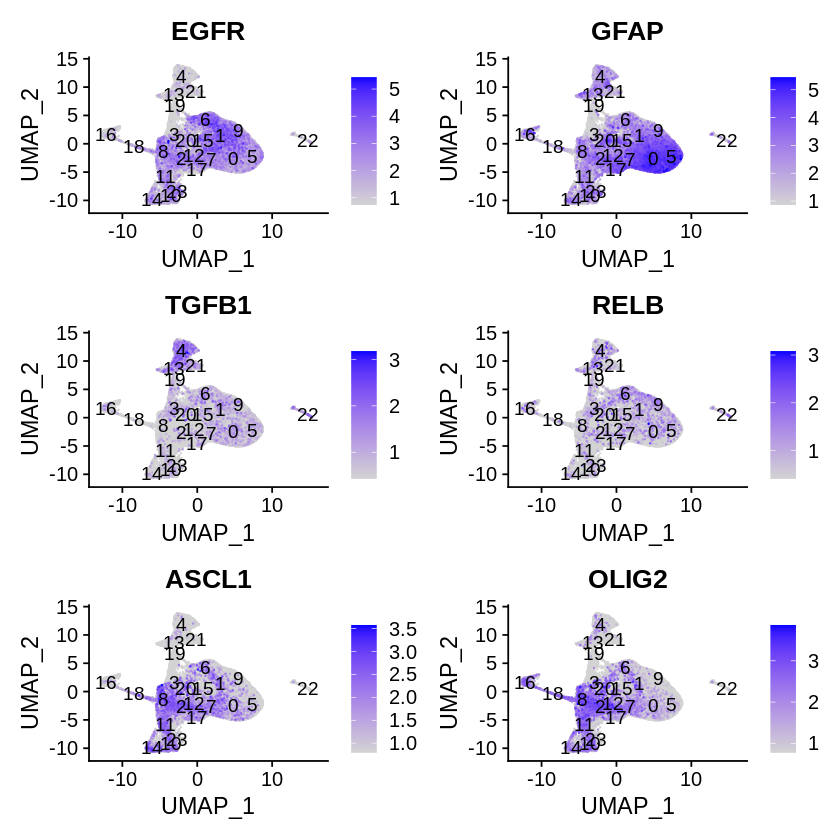

png 
  2

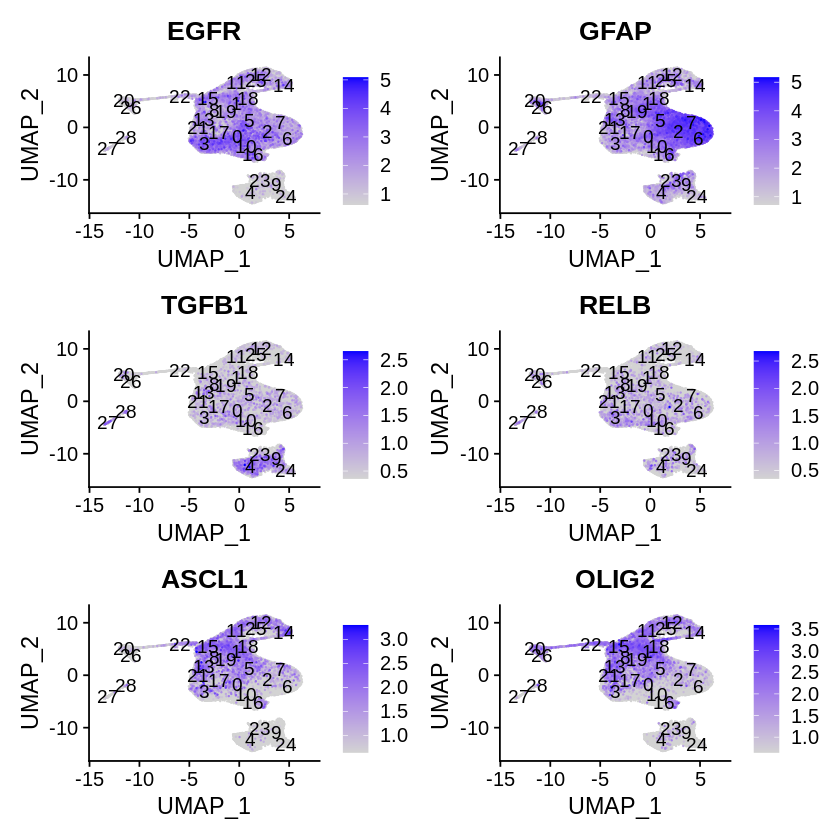

In [19]:
p1 <- FeaturePlot(gbmsc_ge19, 
            reduction = "umap", 
            features = c('EGFR', 'GFAP', "TGFB1","RELB", 'ASCL1', 'OLIG2'), 
            order = TRUE, #replaces sort.cell = TRUE
            min.cutoff = 'q10', 
            label = TRUE)
p2 <- FeaturePlot(gbmsc_gte20, 
            reduction = "umap", 
            features = c('EGFR', 'GFAP', "TGFB1","RELB", 'ASCL1', 'OLIG2'), 
            order = TRUE, #replaces sort.cell = TRUE
            min.cutoff = 'q10', 
            label = TRUE)
p1
p2

# Save UMAP for genes
size = 7
pdf("/home/samkyy/scratch/gete-gbm/results/2021-08-02/r_gbmsc-v2_GBMsubtypeMarkers.pdf", width = size*2, height = size*3)
p1
p2
dev.off()

Cell Cycle Markers

| Cell Cycle Phase | Markers      |
|------------------|--------------|
| S-Phase          | TOP2A, MKI67 |
| G1 Phase         | PCNA MCM6    |

In [40]:
DefaultAssay(gbmsc_ge19) <- "integrated"
DefaultAssay(gbmsc_gte20) <- "integrated"
match(c('TOP2A', 'MKI67', 'PCNA', 'MCM6'), rownames(gbmsc_ge19))
match(c('TOP2A', 'MKI67', 'PCNA', 'MCM6'), rownames(gbmsc_gte20))

[1]  20  60 733  NA

[1]   21   69  761 2000

In [41]:
DefaultAssay(gbmsc_ge19) <- "RNA"
DefaultAssay(gbmsc_gte20) <- "RNA"
match(c('TOP2A', 'MKI67', 'PCNA', 'MCM6'), rownames(gbmsc_ge19))
match(c('TOP2A', 'MKI67', 'PCNA', 'MCM6'), rownames(gbmsc_gte20))

[1] 17384 11518 20017  3049

[1] 17383 11517 20016  3049

In [ ]:
p1 <- FeaturePlot(gbmsc_ge19, 
            reduction = "umap", 
            features = c('TOP2A', 'MKI67', 'PCNA', 'MCM6'), 
            order = TRUE, #replaces sort.cell = TRUE
            min.cutoff = 'q10', 
            label = TRUE)
p2 <- FeaturePlot(gbmsc_gte20, 
            reduction = "umap", 
            features = c('TOP2A', 'MKI67', 'PCNA', 'MCM6'), 
            order = TRUE, #replaces sort.cell = TRUE
            min.cutoff = 'q10', 
            label = TRUE)
p1 
p2

# Save UMAP for genes
size = 7
pdf("/home/samkyy/scratch/gete-gbm/results/2021-08-02/r_gbmsc-v2_CCMarkers.pdf", width = size*2, height = size*2)
p1
p2
dev.off()

## Trajectory Analysis
2021-08-03:

In [4]:
source("~/scratch/gete-gbm/bin/util_monocle3.R") 
# don't load the libraries in the first section, because the libraries will conflict. 

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with


In [6]:
gbmsc_ge19 <- readRDS("~/scratch/gete-gbm/results/2021-08-02/gbmsc_ge-PC19.rds")
gbmsc_gte20 <- readRDS("~/scratch/gete-gbm/results/2021-08-02/gbmsc_gte-PC20.rds")

In [7]:
### Use Seurat Wrapper
DefaultAssay(gbmsc_ge19)
DefaultAssay(gbmsc_gte20)

[1] "integrated"

[1] "integrated"

In [14]:
DefaultAssay(gbmsc_ge19) <- "integrated"
DefaultAssay(gbmsc_gte20) <- "integrated"

cds_ge <- as.cell_data_set(gbmsc_ge19)
cds_gte <- as.cell_data_set(gbmsc_gte20)

## Group cells into clusters
cds_ge <- cluster_cells(cds_ge)
cds_gte <- cluster_cells(cds_gte)

Warning message:
"Monocle 3 trajectories require cluster partitions, which Seurat does not calculate. Please run 'cluster_cells' on your cell_data_set object"
Warning message:
"Monocle 3 trajectories require cluster partitions, which Seurat does not calculate. Please run 'cluster_cells' on your cell_data_set object"


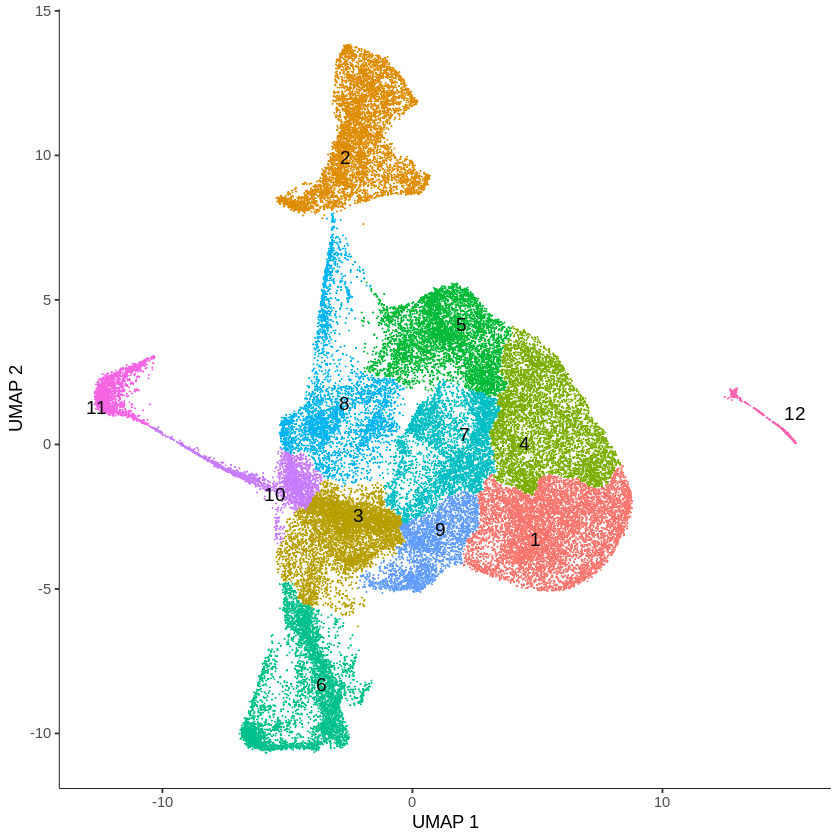

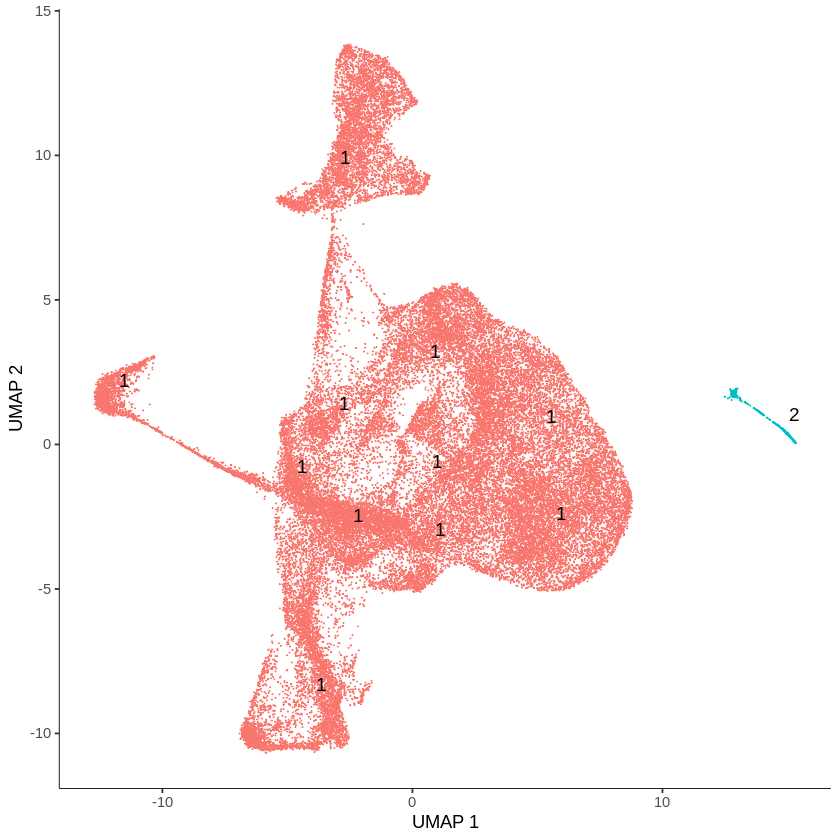

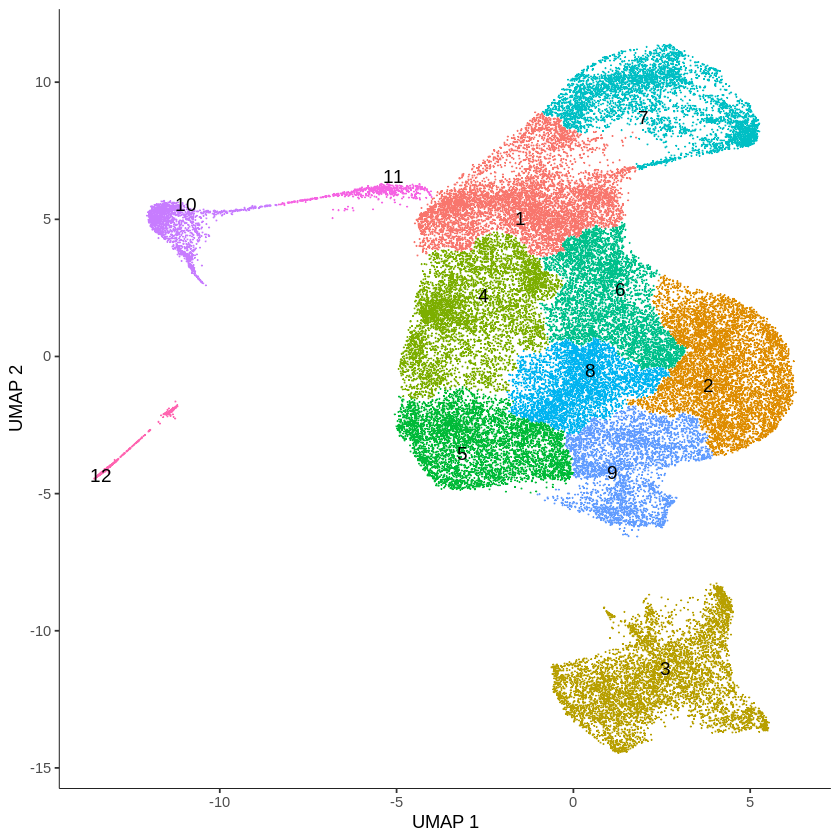

png 
  2

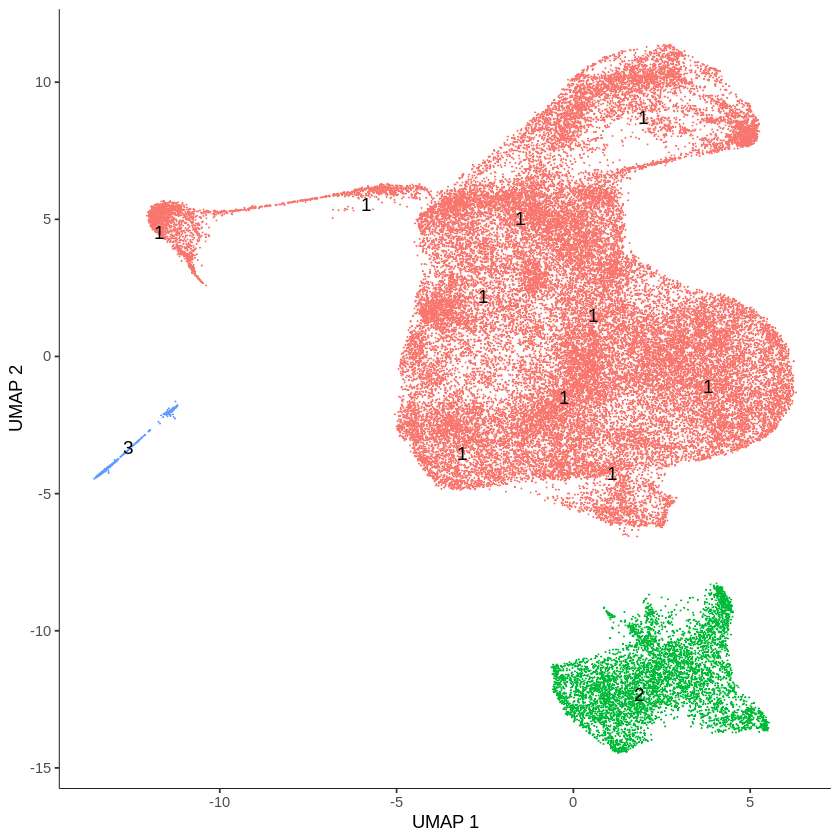

In [15]:
p1 <- plot_cells(cds_ge, show_trajectory_graph = FALSE, group_label_size = 4)
p2 <- plot_cells(cds_ge, color_cells_by = "partition", show_trajectory_graph = FALSE, group_label_size = 4)

p3 <- plot_cells(cds_gte, show_trajectory_graph = FALSE, group_label_size = 4)
p4 <- plot_cells(cds_gte, color_cells_by = "partition", show_trajectory_graph = FALSE, group_label_size = 4)

p1
p2
p3
p4

# Save figures

size = 7
pdf("/home/samkyy/scratch/gete-gbm/results/2021-08-02/r_gbmsc-v2_monocleUMAPs.pdf", width = size*2, height = size*2)
grid.arrange(p1, p3, p2, p4, nrow = 2, top="Trajectory Analysis: Monocle Clusters vs Partitions")
dev.off()

In [25]:
saveRDS(cds_ge, file="~/scratch/gete-gbm/results/2021-08-02/cds_ge.rds")
saveRDS(cds_gte, file="~/scratch/gete-gbm/results/2021-08-02/cds_gte.rds")

In [6]:
cds_ge <- readRDS("~/scratch/gete-gbm/results/2021-08-02/cds_ge.rds")
cds_gte <- readRDS("~/scratch/gete-gbm/results/2021-08-02/cds_gte.rds")

In [7]:
## Select Island to study the trajectory on:
integrated.sub_ge <- subset(as.Seurat(cds_ge), monocle3_partitions == 1)
integrated.sub_gte <- subset(as.Seurat(cds_gte), monocle3_partitions == 1)

In [8]:
## Convert back to monocle object and learn the graph
cds_ge2 <- as.cell_data_set(integrated.sub_ge)
cds_ge2 <- learn_graph(cds_ge2)

cds_gte2 <- as.cell_data_set(integrated.sub_gte)
cds_gte2 <- learn_graph(cds_gte2)

Using existing Monocle 3 cluster membership and partitions



  |======================================================================| 100%


Using existing Monocle 3 cluster membership and partitions



  |======================================================================| 100%


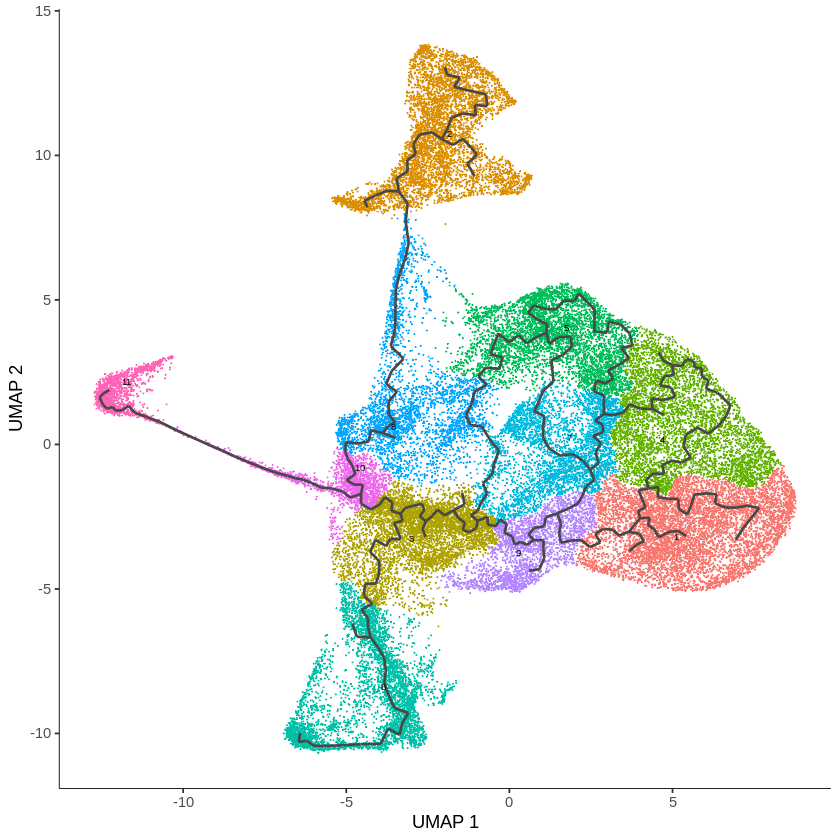

png 
  2

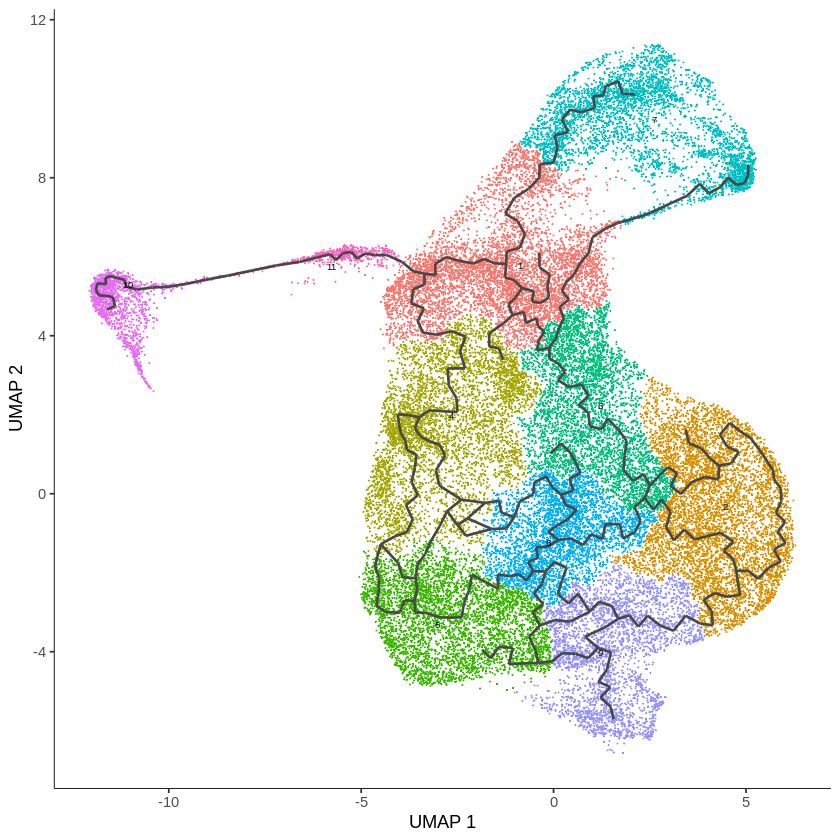

In [22]:
p1 <- plot_cells(cds_ge2, label_groups_by_cluster = FALSE, label_leaves = FALSE, label_branch_points = FALSE)

p2 <- plot_cells(cds_gte2, label_groups_by_cluster = FALSE, label_leaves = FALSE, label_branch_points = FALSE)

p1
p2

# Save figures

size = 7
pdf("/home/samkyy/scratch/gete-gbm/results/2021-08-02/r_gbmsc-v2_monocle_pathsVSclusters.pdf", width = size*2, height = size)
grid.arrange(p1, p2, nrow=1, top="Trajectory Analysis: Trajectories VS Clusters")
dev.off()

In [32]:
## Select root cells
    ##GE_PC19_r0.2: Cluster 7
    ##GTE_PC20_r0.2: Cluster 7

root_cells_ge <- rownames(integrated.sub_ge@meta.data[which(FetchData(integrated.sub_ge, 
                                                                      "integrated_snn_res.0.2") == 7),])
root_cells_gte <- rownames(integrated.sub_gte@meta.data[which(FetchData(integrated.sub_gte, 
                                                                      "integrated_snn_res.0.2") == 7),])

## Order Cells
cds_ge3 <- order_cells(cds_ge2, root_cells = root_cells_ge)
cds_gte3 <- order_cells(cds_gte2, root_cells = root_cells_gte)

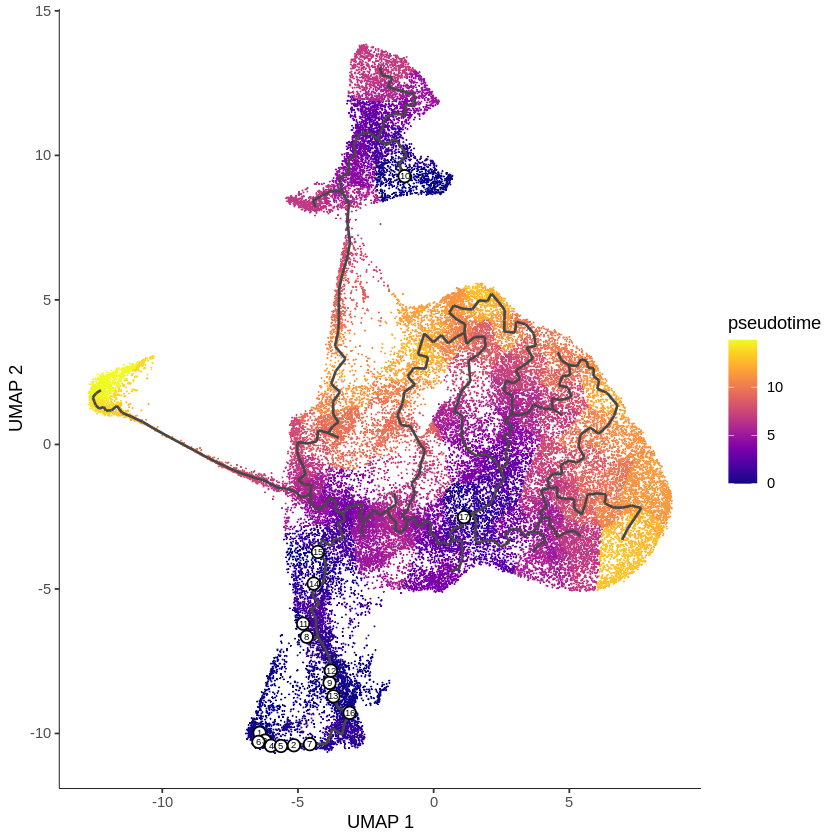

png 
  2

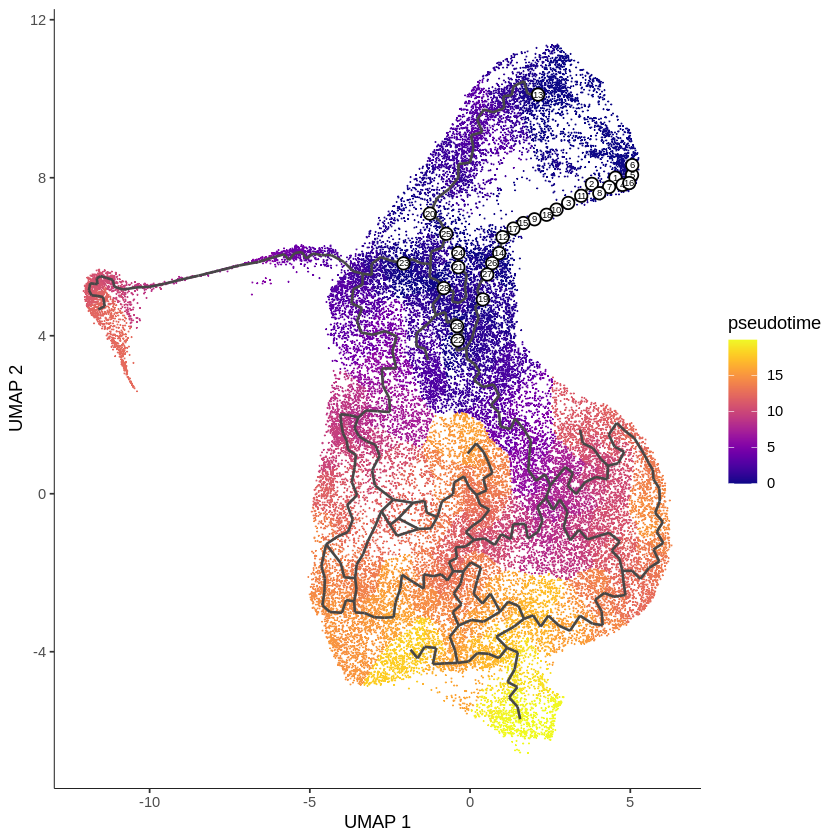

In [34]:
## Plot Pseudotime Graph
p1 <- plot_cells(cds_ge3, color_cells_by = "pseudotime", 
           label_cell_groups = FALSE, label_leaves = FALSE, label_branch_points = FALSE)

p2 <- plot_cells(cds_gte3, color_cells_by = "pseudotime", 
           label_cell_groups = FALSE, label_leaves = FALSE, label_branch_points = FALSE)

p1
p2

# Save figures

size = 7
pdf("/home/samkyy/scratch/gete-gbm/results/2021-08-02/r_gbmsc-v2_monocle_pseudotime.pdf", width = size*2, height = size)
grid.arrange(p1, p2, nrow=1, top="Trajectory Analysis: Pseudotime")
dev.off()

In [35]:
saveRDS(cds_ge3, file="~/scratch/gete-gbm/results/2021-08-02/cds_pseudo_clus7_ge.rds")
saveRDS(cds_gte3, file="~/scratch/gete-gbm/results/2021-08-02/cds_pseudo__clus7_gte.rds")

Taking the Seurat clusters seems to have set some outlier nodes on the other side of the UMAP space as root cells. The isn't ideal. To mitigate that I set the roots using the monocle.clusters instead and it gave more expected results. 

In [38]:
## Select root cells
    ##GE_PC19_r0.2: monocle Cluster 6
    ##GTE_PC20_r0.2: monocle Cluster 7

root_cells_ge <- rownames(integrated.sub_ge@meta.data[which(FetchData(integrated.sub_ge, 
                                                                      "monocle3_clusters") == 6),])
root_cells_gte <- rownames(integrated.sub_gte@meta.data[which(FetchData(integrated.sub_gte, 
                                                                      "monocle3_clusters") == 7),])

## Order Cells in Pseudotime along a trajectory
cds_ge3 <- order_cells(cds_ge2, root_cells = root_cells_ge)
cds_gte3 <- order_cells(cds_gte2, root_cells = root_cells_gte)

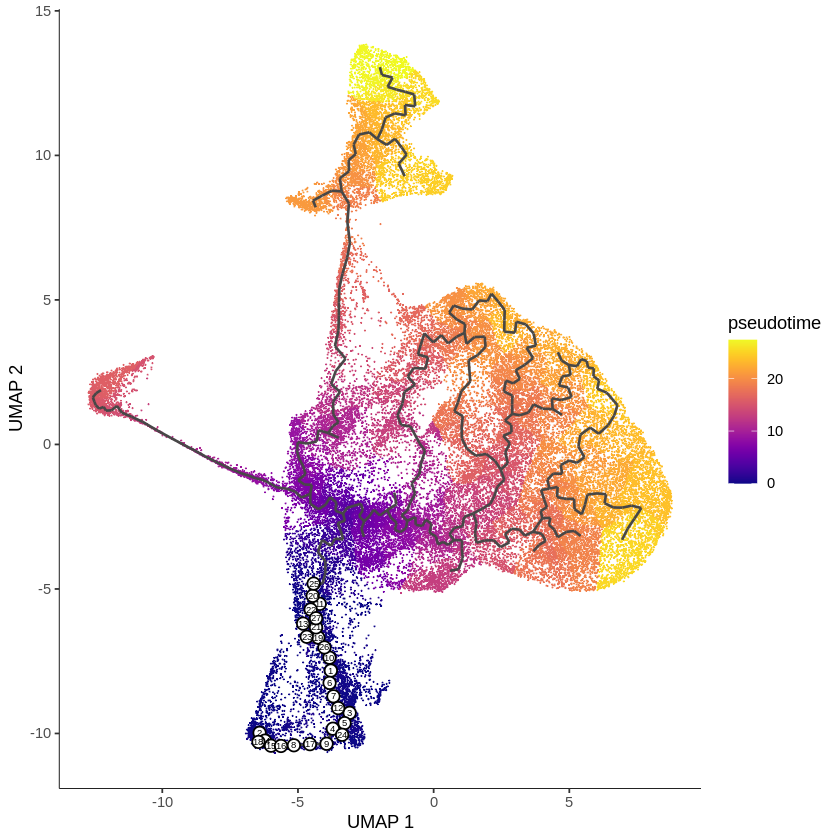

png 
  2

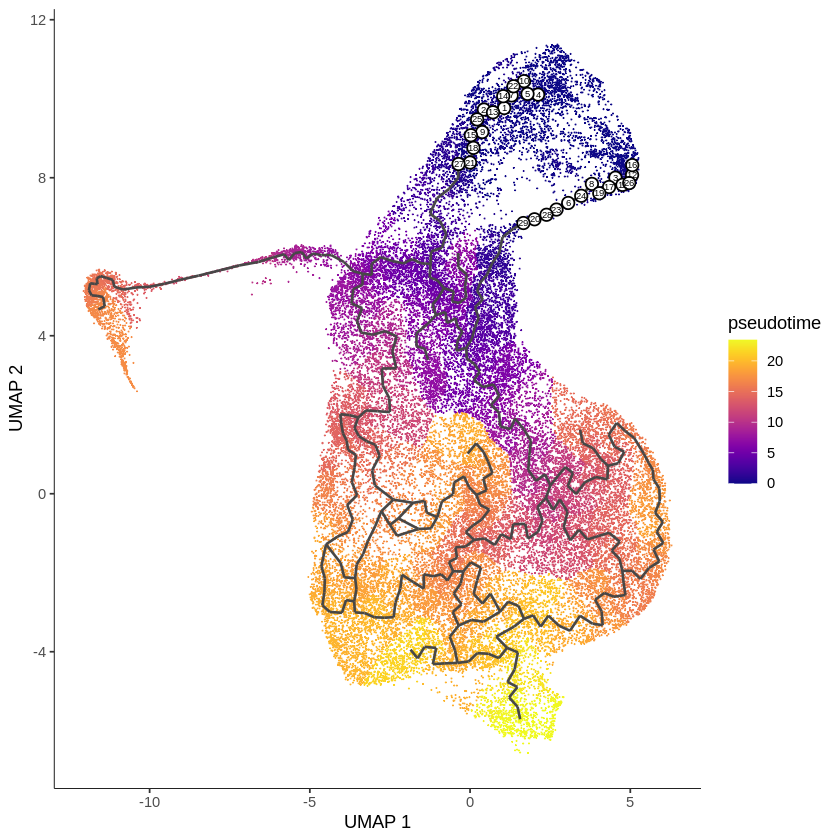

In [39]:
## Plot Pseudotime Graph
p1 <- plot_cells(cds_ge3, color_cells_by = "pseudotime", 
           label_cell_groups = FALSE, label_leaves = FALSE, label_branch_points = FALSE)

p2 <- plot_cells(cds_gte3, color_cells_by = "pseudotime", 
           label_cell_groups = FALSE, label_leaves = FALSE, label_branch_points = FALSE)

p1
p2

# Save figures

size = 7
pdf("/home/samkyy/scratch/gete-gbm/results/2021-08-02/r_gbmsc-v2_monocle_pseudotime_mclus6-7.pdf", width = size*2, height = size)
grid.arrange(p1, p2, nrow=1, top="Trajectory Analysis: Pseudotime")
dev.off()

In [40]:
saveRDS(cds_ge3, file="~/scratch/gete-gbm/results/2021-08-02/cds_pseudo_monoclus6_ge.rds")
saveRDS(cds_gte3, file="~/scratch/gete-gbm/results/2021-08-02/cds_pseudo__monoclus7_gte.rds")

In [37]:
integrated.sub_ge3 <- as.Seurat(cds_ge3, assay = "integrated")
integrated.sub_gte3 <- as.Seurat(cds_gte3, assay = "integrated")

FeaturePlot(integrated.sub_ge3, "monocle3_pseudotime")
FeaturePlot(integrated.sub_gte3, "monocle3_pseudotime")

Warning message in FetchData(object = object, vars = c(dims, "ident", features), :
"The following requested variables were not found: monocle3_pseudotime"


ERROR: Error: None of the requested features were found: monocle3_pseudotime in slot data


In [5]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/imkl/2020.1.217/compilers_and_libraries_2020.1.217/linux/mkl/lib/intel64_lin/libmkl_gf_lp64.so

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] magrittr_2.0.1              patchwork_1.1.1            
 [3] ggplot2_3.3.5               SeuratWrappers_0.3.0       
 [5] SeuratObject_4.0.0          Seurat_4.0.1               
 [7] mon